# Notional Example Problem

An analytic problem for understanding resilience optimization structures.

In [330]:
import sys
sys.path.append('../')
import numpy as np
import scipy as sp
import time
import itertools
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint

This problem considers different architectures to structure the optimization of resilience. In general, the resilience of a system is a function of the performance curve which results from a given hazardous scenario. Consider, for example, the curve shown below, where a fault causes the system to perform in a worse condition (given by $x_a$) for a given amount of time $x_b$, before it is recovered over a given amount of time $x_c$.

<h3 align="center">System Resilience to Considered Fault Scenario</h3> 

![Resilience of the System to Fault](notionalsystem.png)

In an integrated resilience optimization formulation of this problem, the goal is to optimize the design/operations of the system with the resilience variables simultaneously to balance the resilience of the system with design/operational considerations. This involves (at least) two models of cost: design/operational cost and resilience cost.

## Design/Operational Cost

The design model specifies the inherent resilience in the system that results from the way it was designed/is operated when there is no hazardous scenario. In this model, the variables are $x_p$, the overall performance of the system, $x_a$, the lost performance during the scenario, $x_s$, the slack in the system, and $x_r$, the hazard rate. The terms a-f and n are constants.

In [331]:
xdes = [1,1,1,0]
xdb = ((1e-6,100),(1e-6,100),(1e-6,100),(1e-6,100))
# xdes = [x_p, x_a, x_r, x_s]
# index:   0    1    2    3
# constants: [a,b,c,n,d,e,f]
# inds:       0,1,2,3,4,5,6
const =[1e6,1e5,1e4,10,1e5,200,500]

The Design/Operational cost model for this system is: $C_D = a*(x_p-1)^2 +b*x_s^2 + \frac{c}{x_r}$ 

The terms in the cost model captures the value of having increased performance, the waste of running the system with excess slack, and the cost of maintaining the system at a certain level of reliability.

In [384]:
def des_cost(xdes,const):
    return const[0]*(xdes[0]-1)**2 + const[1]*xdes[3]**2 + const[2]/max(xdes[2],1e-10)

Subject to the equality constraint: $h_D = x_p -(x_s + x_a) = 0$, which captures the relationship between slack, performance, and lost performance during the scenario.

In [385]:
def des_h_const(xdes):
    return xdes[0]-(xdes[3]+xdes[1])

There is also an inequality constraint: $g_D = 10^{-x_a} - x_r$, which specifies a lower bound on how reliable the system can be when it is running with a certain amount of slack (in the specified relationship, high slack makes the system less reliable).

In [386]:
def des_g_const(xdes):
    return np.power(10.0, -xdes[1]) - xdes[2]

## Resilience Model

The resilience model specifies how the system performes in the hazardous scenario(s) based on variables which may be leveraged during this scenario. In this system, there are two variables--$x_b$, the length of time the system stays in the hazardous scenario before it is repaired, and $x_c$, the length of time it takes to repair the system.

In [387]:
xres = [1,  1]
#ind:   0   1
#full:  4   5
#lab:   x_b,x_c
xrb = ((1e-6,100), (1e-6,100))

In this system, the resilience model is specified with a cost function:

$C_R = x_r*n*(d*x_a*(x_b+x_c/2) + e/x_c + f/x_b))$

which considers the cost as a function of the area between the nominal performance and the resilience curve (the cost of the hazard's direct consequences), along with a cost of short recovery time and a cost of short repair time (the cost of restoring the system to nominal performance at a certain speed).

In [388]:
def res_cost(xres,xdes,const):
    return xdes[2] * const[3] * (const[4]*xdes[1]*((xres[0]+xres[1]/2) + const[5]/max(xres[1],1e-6))+const[6]/max(xres[0],1e-6))

## Optimization Architectures

This problem can be solved using a number of solution architectures. This section presents and compares the all-at-once, bilevel, and alternating optimization structures.


<h3 align="center">All-at-once Architecture</h3> 

![All-at-once Architecture](allatonce.png)

The all-at-once architecture is an optimization strategy where the entire problem is solved in a single *monolithic* formulation, with the overall objective $C = C_D + C_R$

In [389]:
def x_to_totcost_mono(x, const):
    return des_cost(x, const) + res_cost(x[4:],x, const)

In [390]:
#used to keep track of optimization progress
history = []
def callbackF(Xdes, result):
    history.append(result['fun'])

Below, the trust-region constrained algorithm is used to optimize this problem. As implemented, the algorithm does not reach a convergence criteria and instead finishes after reaching the maximum number of steps (1000)

In [391]:
# all-in-one 
x = xdes + xres
xb = xdb + xrb
history = []
starttime = time.time()
constraints = [{'type':'eq', 'fun': lambda x: x[0]-(x[3]+x[1]), 'jac': lambda x: np.array([1,-1,0,-1,0,0])}, {'type':'ineq', 'fun': lambda x: np.power(10.0, -x[1]) - x[2], 'jac': lambda x: np.array([0, -np.log(10)*np.power(10.0, -x[1]), -1, 0,0,0]) }]
result_aao = minimize(x_to_totcost_mono, x, method='trust-constr', bounds = xb, constraints =constraints, args = const, callback=callbackF, options={'maxiter':1e4, 'verbose':2})
time_aao = time.time() - starttime
aao_history = history

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   7   |   0   | +2.0152e+08 | 1.00e+00 | 1.38e+08 | 9.00e-01 |
|   2   |  14   |   1   | +9.8301e+07 | 2.00e+00 | 5.58e+07 | 6.54e-01 |
|   3   |  21   |   6   | +4.3338e+07 | 6.03e+00 | 2.10e+07 | 3.09e-01 |
|   4   |  28   |  11   | +1.2273e+07 | 6.71e+00 | 5.25e+06 | 5.21e-04 |
|   5   |  35   |  16   | +2.7551e+06 | 7.25e+00 | 1.00e+06 | 3.37e-05 |
|   6   |  42   |  21   | +1.1935e+06 | 7.25e+00 | 1.48e+05 | 4.44e-16 |
|   7   |  56   |  26   | +1.1935e+06 | 7.25e-01 | 1.48e+05 | 4.44e-16 |
|   8   |  63   |  31   | +9.7859e+05 | 5.07e+00 | 8.09e+04 | 5.55e-16 |
|   9   |  70   |  36   | +6.0602e+05 | 1.01e+01 | 8.02e+04 | 2.78e-16 |
|  10   |  77   |  41   | +5.7518e+05 | 1.01e+01 | 8.04e+04 | 2.78e-16 |
|  11   |  84   |  45   | +5.0517e+05 | 1.01e+01 | 8.11e+04 | 1.11e-16 |
|  12   |  91   |  49   | +4.6358e+05 | 1.01e+01 | 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)



|  55   |  392  |  196  | +1.1128e+05 | 1.01e+01 | 3.12e+04 | 0.00e+00 |
|  56   |  399  |  199  | +1.1077e+05 | 1.01e+01 | 2.98e+04 | 0.00e+00 |
|  57   |  406  |  202  | +1.1031e+05 | 1.01e+01 | 2.84e+04 | 1.11e-16 |
|  58   |  413  |  205  | +1.0990e+05 | 1.01e+01 | 2.71e+04 | 1.11e-16 |
|  59   |  420  |  208  | +1.0952e+05 | 1.01e+01 | 2.58e+04 | 0.00e+00 |
|  60   |  427  |  211  | +1.0919e+05 | 1.01e+01 | 2.46e+04 | 0.00e+00 |
|  61   |  434  |  214  | +1.0888e+05 | 1.01e+01 | 2.35e+04 | 1.11e-16 |
|  62   |  441  |  217  | +1.0861e+05 | 1.01e+01 | 2.23e+04 | 0.00e+00 |
|  63   |  448  |  220  | +1.0836e+05 | 1.01e+01 | 2.13e+04 | 0.00e+00 |
|  64   |  455  |  223  | +1.0814e+05 | 1.01e+01 | 2.03e+04 | 1.11e-16 |
|  65   |  462  |  226  | +1.0794e+05 | 1.01e+01 | 1.93e+04 | 0.00e+00 |
|  66   |  469  |  229  | +1.0776e+05 | 1.01e+01 | 1.84e+04 | 0.00e+00 |
|  67   |  476  |  232  | +1.0760e+05 | 1.01e+01 | 1.75e+04 | 1.11e-16 |
|  68   |  483  |  235  | +1.0745e+05 | 1.01e+01 |

|  171  | 1204  |  544  | +1.0609e+05 | 1.01e+01 | 2.54e+03 | 1.11e-16 |
|  172  | 1211  |  547  | +1.0609e+05 | 1.01e+01 | 2.54e+03 | 0.00e+00 |
|  173  | 1218  |  550  | +1.0609e+05 | 1.01e+01 | 2.54e+03 | 0.00e+00 |
|  174  | 1225  |  553  | +1.0609e+05 | 1.01e+01 | 2.54e+03 | 0.00e+00 |
|  175  | 1232  |  556  | +1.0609e+05 | 1.01e+01 | 2.54e+03 | 0.00e+00 |
|  176  | 1239  |  559  | +1.0609e+05 | 1.01e+01 | 2.54e+03 | 1.11e-16 |
|  177  | 1246  |  562  | +1.0609e+05 | 1.01e+01 | 2.54e+03 | 1.11e-16 |
|  178  | 1253  |  565  | +1.0609e+05 | 1.01e+01 | 2.54e+03 | 0.00e+00 |
|  179  | 1260  |  568  | +1.0609e+05 | 1.01e+01 | 2.54e+03 | 0.00e+00 |
|  180  | 1267  |  571  | +1.0609e+05 | 1.01e+01 | 2.54e+03 | 0.00e+00 |
|  181  | 1274  |  574  | +1.0609e+05 | 1.01e+01 | 2.54e+03 | 0.00e+00 |
|  182  | 1281  |  577  | +1.0609e+05 | 1.01e+01 | 2.54e+03 | 0.00e+00 |
|  183  | 1288  |  580  | +1.0609e+05 | 1.01e+01 | 2.54e+03 | 1.11e-16 |
|  184  | 1295  |  583  | +1.0609e+05 | 1.01e+01 | 

|  289  | 2030  |  881  | +1.0607e+05 | 1.01e+01 | 2.53e+03 | 0.00e+00 |
|  290  | 2037  |  884  | +1.0607e+05 | 1.01e+01 | 2.53e+03 | 1.11e-16 |
|  291  | 2044  |  887  | +1.0607e+05 | 1.01e+01 | 2.53e+03 | 0.00e+00 |
|  292  | 2051  |  890  | +1.0607e+05 | 1.01e+01 | 2.53e+03 | 0.00e+00 |
|  293  | 2058  |  893  | +1.0607e+05 | 1.01e+01 | 2.53e+03 | 0.00e+00 |
|  294  | 2065  |  896  | +1.0607e+05 | 1.01e+01 | 2.53e+03 | 0.00e+00 |
|  295  | 2072  |  899  | +1.0607e+05 | 1.01e+01 | 2.53e+03 | 0.00e+00 |
|  296  | 2079  |  902  | +1.0607e+05 | 1.01e+01 | 2.53e+03 | 0.00e+00 |
|  297  | 2086  |  905  | +1.0607e+05 | 1.01e+01 | 2.53e+03 | 0.00e+00 |
|  298  | 2093  |  908  | +1.0606e+05 | 1.01e+01 | 2.53e+03 | 0.00e+00 |
|  299  | 2100  |  911  | +1.0606e+05 | 1.01e+01 | 2.53e+03 | 1.11e-16 |
|  300  | 2107  |  914  | +1.0606e+05 | 1.01e+01 | 2.53e+03 | 0.00e+00 |
|  301  | 2114  |  917  | +1.0606e+05 | 1.01e+01 | 2.53e+03 | 0.00e+00 |
|  302  | 2121  |  920  | +1.0606e+05 | 1.01e+01 | 

|  404  | 2835  | 1226  | +1.0604e+05 | 1.01e+01 | 2.52e+03 | 0.00e+00 |
|  405  | 2842  | 1229  | +1.0604e+05 | 1.01e+01 | 2.52e+03 | 0.00e+00 |
|  406  | 2849  | 1232  | +1.0604e+05 | 1.01e+01 | 2.52e+03 | 0.00e+00 |
|  407  | 2856  | 1235  | +1.0604e+05 | 1.01e+01 | 2.52e+03 | 1.11e-16 |
|  408  | 2863  | 1238  | +1.0604e+05 | 1.01e+01 | 2.52e+03 | 1.11e-16 |
|  409  | 2870  | 1241  | +1.0604e+05 | 1.01e+01 | 2.52e+03 | 1.11e-16 |
|  410  | 2877  | 1244  | +1.0604e+05 | 1.01e+01 | 2.52e+03 | 0.00e+00 |
|  411  | 2884  | 1247  | +1.0604e+05 | 1.01e+01 | 2.52e+03 | 1.11e-16 |
|  412  | 2891  | 1250  | +1.0604e+05 | 1.01e+01 | 2.52e+03 | 0.00e+00 |
|  413  | 2898  | 1253  | +1.0604e+05 | 1.01e+01 | 2.52e+03 | 0.00e+00 |
|  414  | 2905  | 1256  | +1.0604e+05 | 1.01e+01 | 2.52e+03 | 0.00e+00 |
|  415  | 2912  | 1259  | +1.0604e+05 | 1.01e+01 | 2.52e+03 | 0.00e+00 |
|  416  | 2919  | 1262  | +1.0604e+05 | 1.01e+01 | 2.52e+03 | 0.00e+00 |
|  417  | 2926  | 1265  | +1.0604e+05 | 1.01e+01 | 

|  523  | 3668  | 1583  | +1.0602e+05 | 1.01e+01 | 2.51e+03 | 1.11e-16 |
|  524  | 3675  | 1586  | +1.0602e+05 | 1.01e+01 | 2.51e+03 | 0.00e+00 |
|  525  | 3682  | 1589  | +1.0602e+05 | 1.01e+01 | 2.51e+03 | 0.00e+00 |
|  526  | 3689  | 1592  | +1.0602e+05 | 1.01e+01 | 2.51e+03 | 0.00e+00 |
|  527  | 3696  | 1595  | +1.0602e+05 | 1.01e+01 | 2.51e+03 | 1.11e-16 |
|  528  | 3703  | 1598  | +1.0602e+05 | 1.01e+01 | 2.51e+03 | 0.00e+00 |
|  529  | 3710  | 1601  | +1.0602e+05 | 1.01e+01 | 2.51e+03 | 0.00e+00 |
|  530  | 3717  | 1604  | +1.0602e+05 | 1.01e+01 | 2.51e+03 | 0.00e+00 |
|  531  | 3724  | 1607  | +1.0602e+05 | 1.01e+01 | 2.51e+03 | 0.00e+00 |
|  532  | 3731  | 1610  | +1.0602e+05 | 1.01e+01 | 2.51e+03 | 1.11e-16 |
|  533  | 3738  | 1613  | +1.0602e+05 | 1.01e+01 | 2.51e+03 | 0.00e+00 |
|  534  | 3745  | 1616  | +1.0602e+05 | 1.01e+01 | 2.51e+03 | 1.11e-16 |
|  535  | 3752  | 1619  | +1.0602e+05 | 1.01e+01 | 2.51e+03 | 0.00e+00 |
|  536  | 3759  | 1622  | +1.0602e+05 | 1.01e+01 | 

|  682  | 4781  | 2060  | +1.0599e+05 | 1.01e+01 | 2.49e+03 | 0.00e+00 |
|  683  | 4788  | 2063  | +1.0599e+05 | 1.01e+01 | 2.49e+03 | 1.11e-16 |
|  684  | 4795  | 2066  | +1.0599e+05 | 1.01e+01 | 2.49e+03 | 0.00e+00 |
|  685  | 4802  | 2069  | +1.0599e+05 | 1.01e+01 | 2.49e+03 | 0.00e+00 |
|  686  | 4809  | 2072  | +1.0599e+05 | 1.01e+01 | 2.49e+03 | 0.00e+00 |
|  687  | 4816  | 2075  | +1.0599e+05 | 1.01e+01 | 2.49e+03 | 0.00e+00 |
|  688  | 4823  | 2078  | +1.0599e+05 | 1.01e+01 | 2.49e+03 | 0.00e+00 |
|  689  | 4830  | 2081  | +1.0599e+05 | 1.01e+01 | 2.49e+03 | 0.00e+00 |
|  690  | 4837  | 2084  | +1.0599e+05 | 1.01e+01 | 2.49e+03 | 0.00e+00 |
|  691  | 4844  | 2087  | +1.0599e+05 | 1.01e+01 | 2.49e+03 | 0.00e+00 |
|  692  | 4851  | 2090  | +1.0598e+05 | 1.01e+01 | 2.49e+03 | 0.00e+00 |
|  693  | 4858  | 2093  | +1.0598e+05 | 1.01e+01 | 2.49e+03 | 0.00e+00 |
|  694  | 4865  | 2096  | +1.0598e+05 | 1.01e+01 | 2.49e+03 | 1.11e-16 |
|  695  | 4872  | 2099  | +1.0598e+05 | 1.01e+01 | 

|  801  | 5614  | 2417  | +1.0596e+05 | 1.01e+01 | 2.48e+03 | 0.00e+00 |
|  802  | 5621  | 2420  | +1.0596e+05 | 1.01e+01 | 2.48e+03 | 0.00e+00 |
|  803  | 5628  | 2423  | +1.0596e+05 | 1.01e+01 | 2.48e+03 | 0.00e+00 |
|  804  | 5635  | 2426  | +1.0596e+05 | 1.01e+01 | 2.48e+03 | 0.00e+00 |
|  805  | 5642  | 2429  | +1.0596e+05 | 1.01e+01 | 2.48e+03 | 1.11e-16 |
|  806  | 5649  | 2432  | +1.0596e+05 | 1.01e+01 | 2.48e+03 | 0.00e+00 |
|  807  | 5656  | 2435  | +1.0596e+05 | 1.01e+01 | 2.48e+03 | 0.00e+00 |
|  808  | 5663  | 2438  | +1.0596e+05 | 1.01e+01 | 2.48e+03 | 1.11e-16 |
|  809  | 5670  | 2441  | +1.0596e+05 | 1.01e+01 | 2.48e+03 | 0.00e+00 |
|  810  | 5677  | 2444  | +1.0596e+05 | 1.01e+01 | 2.48e+03 | 1.11e-16 |
|  811  | 5684  | 2447  | +1.0596e+05 | 1.01e+01 | 2.48e+03 | 0.00e+00 |
|  812  | 5691  | 2450  | +1.0596e+05 | 1.01e+01 | 2.48e+03 | 0.00e+00 |
|  813  | 5698  | 2453  | +1.0596e+05 | 1.01e+01 | 2.48e+03 | 1.11e-16 |
|  814  | 5705  | 2456  | +1.0596e+05 | 1.01e+01 | 

|  920  | 6447  | 2774  | +1.0594e+05 | 1.01e+01 | 2.47e+03 | 0.00e+00 |
|  921  | 6454  | 2777  | +1.0594e+05 | 1.01e+01 | 2.47e+03 | 0.00e+00 |
|  922  | 6461  | 2780  | +1.0594e+05 | 1.01e+01 | 2.47e+03 | 1.11e-16 |
|  923  | 6468  | 2783  | +1.0594e+05 | 1.01e+01 | 2.47e+03 | 0.00e+00 |
|  924  | 6475  | 2786  | +1.0594e+05 | 1.01e+01 | 2.47e+03 | 0.00e+00 |
|  925  | 6482  | 2789  | +1.0594e+05 | 1.01e+01 | 2.47e+03 | 0.00e+00 |
|  926  | 6489  | 2792  | +1.0594e+05 | 1.01e+01 | 2.47e+03 | 0.00e+00 |
|  927  | 6496  | 2795  | +1.0594e+05 | 1.01e+01 | 2.47e+03 | 0.00e+00 |
|  928  | 6503  | 2798  | +1.0594e+05 | 1.01e+01 | 2.47e+03 | 0.00e+00 |
|  929  | 6510  | 2801  | +1.0594e+05 | 1.01e+01 | 2.47e+03 | 1.11e-16 |
|  930  | 6517  | 2804  | +1.0594e+05 | 1.01e+01 | 2.47e+03 | 1.11e-16 |
|  931  | 6524  | 2807  | +1.0594e+05 | 1.01e+01 | 2.47e+03 | 0.00e+00 |
|  932  | 6531  | 2810  | +1.0594e+05 | 1.01e+01 | 2.47e+03 | 0.00e+00 |
|  933  | 6538  | 2813  | +1.0594e+05 | 1.01e+01 | 

| 1083  | 7588  | 3263  | +1.0591e+05 | 1.01e+01 | 2.45e+03 | 0.00e+00 |
| 1084  | 7595  | 3266  | +1.0591e+05 | 1.01e+01 | 2.45e+03 | 0.00e+00 |
| 1085  | 7602  | 3269  | +1.0591e+05 | 1.01e+01 | 2.45e+03 | 0.00e+00 |
| 1086  | 7609  | 3272  | +1.0591e+05 | 1.01e+01 | 2.45e+03 | 0.00e+00 |
| 1087  | 7616  | 3275  | +1.0591e+05 | 1.01e+01 | 2.45e+03 | 1.11e-16 |
| 1088  | 7623  | 3278  | +1.0591e+05 | 1.01e+01 | 2.45e+03 | 0.00e+00 |
| 1089  | 7630  | 3281  | +1.0591e+05 | 1.01e+01 | 2.45e+03 | 0.00e+00 |
| 1090  | 7637  | 3284  | +1.0591e+05 | 1.01e+01 | 2.45e+03 | 0.00e+00 |
| 1091  | 7644  | 3287  | +1.0591e+05 | 1.01e+01 | 2.45e+03 | 1.11e-16 |
| 1092  | 7651  | 3290  | +1.0591e+05 | 1.01e+01 | 2.45e+03 | 0.00e+00 |
| 1093  | 7658  | 3293  | +1.0591e+05 | 1.01e+01 | 2.45e+03 | 0.00e+00 |
| 1094  | 7665  | 3296  | +1.0591e+05 | 1.01e+01 | 2.45e+03 | 0.00e+00 |
| 1095  | 7672  | 3299  | +1.0591e+05 | 1.01e+01 | 2.45e+03 | 0.00e+00 |
| 1096  | 7679  | 3302  | +1.0591e+05 | 1.01e+01 | 

| 1196  | 8379  | 3602  | +1.0589e+05 | 1.01e+01 | 2.44e+03 | 0.00e+00 |
| 1197  | 8386  | 3605  | +1.0589e+05 | 1.01e+01 | 2.44e+03 | 0.00e+00 |
| 1198  | 8393  | 3608  | +1.0589e+05 | 1.01e+01 | 2.44e+03 | 1.11e-16 |
| 1199  | 8400  | 3611  | +1.0589e+05 | 1.01e+01 | 2.44e+03 | 0.00e+00 |
| 1200  | 8407  | 3614  | +1.0589e+05 | 1.01e+01 | 2.44e+03 | 0.00e+00 |
| 1201  | 8414  | 3617  | +1.0589e+05 | 1.01e+01 | 2.44e+03 | 0.00e+00 |
| 1202  | 8421  | 3620  | +1.0589e+05 | 1.01e+01 | 2.44e+03 | 1.11e-16 |
| 1203  | 8428  | 3623  | +1.0589e+05 | 1.01e+01 | 2.44e+03 | 0.00e+00 |
| 1204  | 8435  | 3626  | +1.0589e+05 | 1.01e+01 | 2.44e+03 | 0.00e+00 |
| 1205  | 8442  | 3629  | +1.0589e+05 | 1.01e+01 | 2.44e+03 | 1.11e-16 |
| 1206  | 8449  | 3632  | +1.0589e+05 | 1.01e+01 | 2.44e+03 | 1.11e-16 |
| 1207  | 8456  | 3635  | +1.0589e+05 | 1.01e+01 | 2.44e+03 | 1.11e-16 |
| 1208  | 8463  | 3638  | +1.0589e+05 | 1.01e+01 | 2.44e+03 | 0.00e+00 |
| 1209  | 8470  | 3641  | +1.0589e+05 | 1.01e+01 | 

| 1346  | 9429  | 4052  | +1.0586e+05 | 1.01e+01 | 2.43e+03 | 0.00e+00 |
| 1347  | 9436  | 4055  | +1.0586e+05 | 1.01e+01 | 2.43e+03 | 1.11e-16 |
| 1348  | 9443  | 4058  | +1.0586e+05 | 1.01e+01 | 2.43e+03 | 1.11e-16 |
| 1349  | 9450  | 4061  | +1.0586e+05 | 1.01e+01 | 2.43e+03 | 1.11e-16 |
| 1350  | 9457  | 4064  | +1.0586e+05 | 1.01e+01 | 2.43e+03 | 0.00e+00 |
| 1351  | 9464  | 4067  | +1.0586e+05 | 1.01e+01 | 2.43e+03 | 0.00e+00 |
| 1352  | 9471  | 4070  | +1.0586e+05 | 1.01e+01 | 2.43e+03 | 0.00e+00 |
| 1353  | 9478  | 4073  | +1.0586e+05 | 1.01e+01 | 2.43e+03 | 0.00e+00 |
| 1354  | 9485  | 4076  | +1.0586e+05 | 1.01e+01 | 2.43e+03 | 0.00e+00 |
| 1355  | 9492  | 4079  | +1.0586e+05 | 1.01e+01 | 2.43e+03 | 1.11e-16 |
| 1356  | 9499  | 4082  | +1.0586e+05 | 1.01e+01 | 2.43e+03 | 0.00e+00 |
| 1357  | 9506  | 4085  | +1.0586e+05 | 1.01e+01 | 2.43e+03 | 0.00e+00 |
| 1358  | 9513  | 4088  | +1.0586e+05 | 1.01e+01 | 2.43e+03 | 0.00e+00 |
| 1359  | 9520  | 4091  | +1.0586e+05 | 1.01e+01 | 

| 1496  | 10479 | 4502  | +1.0584e+05 | 1.01e+01 | 2.41e+03 | 0.00e+00 |
| 1497  | 10486 | 4505  | +1.0584e+05 | 1.01e+01 | 2.41e+03 | 0.00e+00 |
| 1498  | 10493 | 4508  | +1.0584e+05 | 1.01e+01 | 2.41e+03 | 1.11e-16 |
| 1499  | 10500 | 4511  | +1.0584e+05 | 1.01e+01 | 2.41e+03 | 0.00e+00 |
| 1500  | 10507 | 4514  | +1.0584e+05 | 1.01e+01 | 2.41e+03 | 0.00e+00 |
| 1501  | 10514 | 4517  | +1.0584e+05 | 1.01e+01 | 2.41e+03 | 0.00e+00 |
| 1502  | 10521 | 4520  | +1.0583e+05 | 1.01e+01 | 2.41e+03 | 0.00e+00 |
| 1503  | 10528 | 4523  | +1.0583e+05 | 1.01e+01 | 2.41e+03 | 0.00e+00 |
| 1504  | 10535 | 4526  | +1.0583e+05 | 1.01e+01 | 2.41e+03 | 1.11e-16 |
| 1505  | 10542 | 4529  | +1.0583e+05 | 1.01e+01 | 2.41e+03 | 0.00e+00 |
| 1506  | 10549 | 4532  | +1.0583e+05 | 1.01e+01 | 2.41e+03 | 0.00e+00 |
| 1507  | 10556 | 4535  | +1.0583e+05 | 1.01e+01 | 2.41e+03 | 1.11e-16 |
| 1508  | 10563 | 4538  | +1.0583e+05 | 1.01e+01 | 2.41e+03 | 0.00e+00 |
| 1509  | 10570 | 4541  | +1.0583e+05 | 1.01e+01 | 

| 1645  | 11522 | 4949  | +1.0581e+05 | 1.01e+01 | 2.40e+03 | 0.00e+00 |
| 1646  | 11529 | 4952  | +1.0581e+05 | 1.01e+01 | 2.40e+03 | 0.00e+00 |
| 1647  | 11536 | 4955  | +1.0581e+05 | 1.01e+01 | 2.40e+03 | 0.00e+00 |
| 1648  | 11543 | 4958  | +1.0581e+05 | 1.01e+01 | 2.40e+03 | 0.00e+00 |
| 1649  | 11550 | 4961  | +1.0581e+05 | 1.01e+01 | 2.40e+03 | 1.11e-16 |
| 1650  | 11557 | 4964  | +1.0581e+05 | 1.01e+01 | 2.40e+03 | 0.00e+00 |
| 1651  | 11564 | 4967  | +1.0581e+05 | 1.01e+01 | 2.40e+03 | 0.00e+00 |
| 1652  | 11571 | 4970  | +1.0581e+05 | 1.01e+01 | 2.40e+03 | 1.11e-16 |
| 1653  | 11578 | 4973  | +1.0581e+05 | 1.01e+01 | 2.40e+03 | 0.00e+00 |
| 1654  | 11585 | 4976  | +1.0581e+05 | 1.01e+01 | 2.40e+03 | 1.11e-16 |
| 1655  | 11592 | 4979  | +1.0581e+05 | 1.01e+01 | 2.40e+03 | 0.00e+00 |
| 1656  | 11599 | 4982  | +1.0581e+05 | 1.01e+01 | 2.40e+03 | 1.11e-16 |
| 1657  | 11606 | 4985  | +1.0581e+05 | 1.01e+01 | 2.40e+03 | 0.00e+00 |
| 1658  | 11613 | 4988  | +1.0581e+05 | 1.01e+01 | 

| 1796  | 12579 | 5402  | +1.0578e+05 | 1.01e+01 | 2.39e+03 | 0.00e+00 |
| 1797  | 12586 | 5405  | +1.0578e+05 | 1.01e+01 | 2.39e+03 | 0.00e+00 |
| 1798  | 12593 | 5408  | +1.0578e+05 | 1.01e+01 | 2.39e+03 | 0.00e+00 |
| 1799  | 12600 | 5411  | +1.0578e+05 | 1.01e+01 | 2.39e+03 | 0.00e+00 |
| 1800  | 12607 | 5414  | +1.0578e+05 | 1.01e+01 | 2.39e+03 | 0.00e+00 |
| 1801  | 12614 | 5417  | +1.0578e+05 | 1.01e+01 | 2.39e+03 | 1.11e-16 |
| 1802  | 12621 | 5420  | +1.0578e+05 | 1.01e+01 | 2.39e+03 | 0.00e+00 |
| 1803  | 12628 | 5423  | +1.0578e+05 | 1.01e+01 | 2.39e+03 | 0.00e+00 |
| 1804  | 12635 | 5426  | +1.0578e+05 | 1.01e+01 | 2.39e+03 | 0.00e+00 |
| 1805  | 12642 | 5429  | +1.0578e+05 | 1.01e+01 | 2.39e+03 | 1.11e-16 |
| 1806  | 12649 | 5432  | +1.0578e+05 | 1.01e+01 | 2.39e+03 | 0.00e+00 |
| 1807  | 12656 | 5435  | +1.0578e+05 | 1.01e+01 | 2.39e+03 | 0.00e+00 |
| 1808  | 12663 | 5438  | +1.0578e+05 | 1.01e+01 | 2.39e+03 | 1.11e-16 |
| 1809  | 12670 | 5441  | +1.0578e+05 | 1.01e+01 | 

| 1949  | 13650 | 5861  | +1.0576e+05 | 1.01e+01 | 2.37e+03 | 0.00e+00 |
| 1950  | 13657 | 5864  | +1.0576e+05 | 1.01e+01 | 2.37e+03 | 1.11e-16 |
| 1951  | 13664 | 5867  | +1.0576e+05 | 1.01e+01 | 2.37e+03 | 1.11e-16 |
| 1952  | 13671 | 5870  | +1.0576e+05 | 1.01e+01 | 2.37e+03 | 0.00e+00 |
| 1953  | 13678 | 5873  | +1.0576e+05 | 1.01e+01 | 2.37e+03 | 1.11e-16 |
| 1954  | 13685 | 5876  | +1.0576e+05 | 1.01e+01 | 2.37e+03 | 0.00e+00 |
| 1955  | 13692 | 5879  | +1.0576e+05 | 1.01e+01 | 2.37e+03 | 0.00e+00 |
| 1956  | 13699 | 5882  | +1.0576e+05 | 1.01e+01 | 2.37e+03 | 0.00e+00 |
| 1957  | 13706 | 5885  | +1.0576e+05 | 1.01e+01 | 2.37e+03 | 1.11e-16 |
| 1958  | 13713 | 5888  | +1.0576e+05 | 1.01e+01 | 2.37e+03 | 0.00e+00 |
| 1959  | 13720 | 5891  | +1.0576e+05 | 1.01e+01 | 2.37e+03 | 0.00e+00 |
| 1960  | 13727 | 5894  | +1.0576e+05 | 1.01e+01 | 2.37e+03 | 0.00e+00 |
| 1961  | 13734 | 5897  | +1.0576e+05 | 1.01e+01 | 2.37e+03 | 0.00e+00 |
| 1962  | 13741 | 5900  | +1.0576e+05 | 1.01e+01 | 

| 2114  | 14805 | 6356  | +1.0573e+05 | 1.01e+01 | 2.36e+03 | 0.00e+00 |
| 2115  | 14812 | 6359  | +1.0573e+05 | 1.01e+01 | 2.36e+03 | 0.00e+00 |
| 2116  | 14819 | 6362  | +1.0573e+05 | 1.01e+01 | 2.36e+03 | 0.00e+00 |
| 2117  | 14826 | 6365  | +1.0573e+05 | 1.01e+01 | 2.36e+03 | 1.11e-16 |
| 2118  | 14833 | 6368  | +1.0573e+05 | 1.01e+01 | 2.36e+03 | 0.00e+00 |
| 2119  | 14840 | 6371  | +1.0573e+05 | 1.01e+01 | 2.36e+03 | 0.00e+00 |
| 2120  | 14847 | 6374  | +1.0573e+05 | 1.01e+01 | 2.36e+03 | 0.00e+00 |
| 2121  | 14854 | 6377  | +1.0573e+05 | 1.01e+01 | 2.36e+03 | 0.00e+00 |
| 2122  | 14861 | 6380  | +1.0573e+05 | 1.01e+01 | 2.36e+03 | 0.00e+00 |
| 2123  | 14868 | 6383  | +1.0573e+05 | 1.01e+01 | 2.36e+03 | 1.11e-16 |
| 2124  | 14875 | 6386  | +1.0573e+05 | 1.01e+01 | 2.36e+03 | 0.00e+00 |
| 2125  | 14882 | 6389  | +1.0573e+05 | 1.01e+01 | 2.36e+03 | 1.11e-16 |
| 2126  | 14889 | 6392  | +1.0573e+05 | 1.01e+01 | 2.36e+03 | 1.11e-16 |
| 2127  | 14896 | 6395  | +1.0573e+05 | 1.01e+01 | 

| 2232  | 15631 | 6710  | +1.0571e+05 | 1.01e+01 | 2.35e+03 | 0.00e+00 |
| 2233  | 15638 | 6713  | +1.0571e+05 | 1.01e+01 | 2.35e+03 | 0.00e+00 |
| 2234  | 15645 | 6716  | +1.0571e+05 | 1.01e+01 | 2.35e+03 | 1.11e-16 |
| 2235  | 15652 | 6719  | +1.0571e+05 | 1.01e+01 | 2.35e+03 | 0.00e+00 |
| 2236  | 15659 | 6722  | +1.0571e+05 | 1.01e+01 | 2.35e+03 | 1.11e-16 |
| 2237  | 15666 | 6725  | +1.0571e+05 | 1.01e+01 | 2.35e+03 | 1.11e-16 |
| 2238  | 15673 | 6728  | +1.0571e+05 | 1.01e+01 | 2.35e+03 | 0.00e+00 |
| 2239  | 15680 | 6731  | +1.0571e+05 | 1.01e+01 | 2.35e+03 | 0.00e+00 |
| 2240  | 15687 | 6734  | +1.0571e+05 | 1.01e+01 | 2.35e+03 | 0.00e+00 |
| 2241  | 15694 | 6737  | +1.0571e+05 | 1.01e+01 | 2.35e+03 | 0.00e+00 |
| 2242  | 15701 | 6740  | +1.0571e+05 | 1.01e+01 | 2.35e+03 | 0.00e+00 |
| 2243  | 15708 | 6743  | +1.0571e+05 | 1.01e+01 | 2.35e+03 | 1.11e-16 |
| 2244  | 15715 | 6746  | +1.0571e+05 | 1.01e+01 | 2.35e+03 | 0.00e+00 |
| 2245  | 15722 | 6749  | +1.0571e+05 | 1.01e+01 | 

| 2348  | 16443 | 7058  | +1.0570e+05 | 1.01e+01 | 2.34e+03 | 0.00e+00 |
| 2349  | 16450 | 7061  | +1.0570e+05 | 1.01e+01 | 2.34e+03 | 1.11e-16 |
| 2350  | 16457 | 7064  | +1.0570e+05 | 1.01e+01 | 2.34e+03 | 0.00e+00 |
| 2351  | 16464 | 7067  | +1.0570e+05 | 1.01e+01 | 2.34e+03 | 0.00e+00 |
| 2352  | 16471 | 7070  | +1.0570e+05 | 1.01e+01 | 2.34e+03 | 0.00e+00 |
| 2353  | 16478 | 7073  | +1.0570e+05 | 1.01e+01 | 2.34e+03 | 0.00e+00 |
| 2354  | 16485 | 7076  | +1.0569e+05 | 1.01e+01 | 2.34e+03 | 0.00e+00 |
| 2355  | 16492 | 7079  | +1.0569e+05 | 1.01e+01 | 2.34e+03 | 1.11e-16 |
| 2356  | 16499 | 7082  | +1.0569e+05 | 1.01e+01 | 2.34e+03 | 0.00e+00 |
| 2357  | 16506 | 7085  | +1.0569e+05 | 1.01e+01 | 2.34e+03 | 0.00e+00 |
| 2358  | 16513 | 7088  | +1.0569e+05 | 1.01e+01 | 2.34e+03 | 0.00e+00 |
| 2359  | 16520 | 7091  | +1.0569e+05 | 1.01e+01 | 2.34e+03 | 0.00e+00 |
| 2360  | 16527 | 7094  | +1.0569e+05 | 1.01e+01 | 2.34e+03 | 0.00e+00 |
| 2361  | 16534 | 7097  | +1.0569e+05 | 1.01e+01 | 

| 2502  | 17521 | 7520  | +1.0567e+05 | 1.01e+01 | 2.33e+03 | 0.00e+00 |
| 2503  | 17528 | 7523  | +1.0567e+05 | 1.01e+01 | 2.33e+03 | 1.11e-16 |
| 2504  | 17535 | 7526  | +1.0567e+05 | 1.01e+01 | 2.33e+03 | 0.00e+00 |
| 2505  | 17542 | 7529  | +1.0567e+05 | 1.01e+01 | 2.33e+03 | 0.00e+00 |
| 2506  | 17549 | 7532  | +1.0567e+05 | 1.01e+01 | 2.33e+03 | 0.00e+00 |
| 2507  | 17556 | 7535  | +1.0567e+05 | 1.01e+01 | 2.33e+03 | 1.11e-16 |
| 2508  | 17563 | 7538  | +1.0567e+05 | 1.01e+01 | 2.33e+03 | 0.00e+00 |
| 2509  | 17570 | 7541  | +1.0567e+05 | 1.01e+01 | 2.33e+03 | 0.00e+00 |
| 2510  | 17577 | 7544  | +1.0567e+05 | 1.01e+01 | 2.33e+03 | 1.11e-16 |
| 2511  | 17584 | 7547  | +1.0567e+05 | 1.01e+01 | 2.33e+03 | 1.11e-16 |
| 2512  | 17591 | 7550  | +1.0567e+05 | 1.01e+01 | 2.33e+03 | 0.00e+00 |
| 2513  | 17598 | 7553  | +1.0567e+05 | 1.01e+01 | 2.33e+03 | 0.00e+00 |
| 2514  | 17605 | 7556  | +1.0567e+05 | 1.01e+01 | 2.33e+03 | 0.00e+00 |
| 2515  | 17612 | 7559  | +1.0567e+05 | 1.01e+01 | 

| 2653  | 18578 | 7973  | +1.0565e+05 | 1.01e+01 | 2.32e+03 | 0.00e+00 |
| 2654  | 18585 | 7976  | +1.0565e+05 | 1.01e+01 | 2.32e+03 | 0.00e+00 |
| 2655  | 18592 | 7979  | +1.0565e+05 | 1.01e+01 | 2.32e+03 | 0.00e+00 |
| 2656  | 18599 | 7982  | +1.0565e+05 | 1.01e+01 | 2.32e+03 | 0.00e+00 |
| 2657  | 18606 | 7985  | +1.0565e+05 | 1.01e+01 | 2.32e+03 | 0.00e+00 |
| 2658  | 18613 | 7988  | +1.0565e+05 | 1.01e+01 | 2.32e+03 | 0.00e+00 |
| 2659  | 18620 | 7991  | +1.0565e+05 | 1.01e+01 | 2.31e+03 | 0.00e+00 |
| 2660  | 18627 | 7994  | +1.0565e+05 | 1.01e+01 | 2.31e+03 | 0.00e+00 |
| 2661  | 18634 | 7997  | +1.0565e+05 | 1.01e+01 | 2.31e+03 | 0.00e+00 |
| 2662  | 18641 | 8000  | +1.0565e+05 | 1.01e+01 | 2.31e+03 | 0.00e+00 |
| 2663  | 18648 | 8003  | +1.0565e+05 | 1.01e+01 | 2.31e+03 | 1.11e-16 |
| 2664  | 18655 | 8006  | +1.0565e+05 | 1.01e+01 | 2.31e+03 | 0.00e+00 |
| 2665  | 18662 | 8009  | +1.0565e+05 | 1.01e+01 | 2.31e+03 | 0.00e+00 |
| 2666  | 18669 | 8012  | +1.0565e+05 | 1.01e+01 | 

| 2809  | 19670 | 8441  | +1.0563e+05 | 1.01e+01 | 2.30e+03 | 0.00e+00 |
| 2810  | 19677 | 8444  | +1.0563e+05 | 1.01e+01 | 2.30e+03 | 1.11e-16 |
| 2811  | 19684 | 8447  | +1.0563e+05 | 1.01e+01 | 2.30e+03 | 0.00e+00 |
| 2812  | 19691 | 8450  | +1.0563e+05 | 1.01e+01 | 2.30e+03 | 1.11e-16 |
| 2813  | 19698 | 8453  | +1.0563e+05 | 1.01e+01 | 2.30e+03 | 0.00e+00 |
| 2814  | 19705 | 8456  | +1.0563e+05 | 1.01e+01 | 2.30e+03 | 0.00e+00 |
| 2815  | 19712 | 8459  | +1.0563e+05 | 1.01e+01 | 2.30e+03 | 0.00e+00 |
| 2816  | 19719 | 8462  | +1.0563e+05 | 1.01e+01 | 2.30e+03 | 1.11e-16 |
| 2817  | 19726 | 8465  | +1.0563e+05 | 1.01e+01 | 2.30e+03 | 0.00e+00 |
| 2818  | 19733 | 8468  | +1.0563e+05 | 1.01e+01 | 2.30e+03 | 0.00e+00 |
| 2819  | 19740 | 8471  | +1.0563e+05 | 1.01e+01 | 2.30e+03 | 0.00e+00 |
| 2820  | 19747 | 8474  | +1.0562e+05 | 1.01e+01 | 2.30e+03 | 1.11e-16 |
| 2821  | 19754 | 8477  | +1.0562e+05 | 1.01e+01 | 2.30e+03 | 0.00e+00 |
| 2822  | 19761 | 8480  | +1.0562e+05 | 1.01e+01 | 

| 2964  | 20755 | 8906  | +1.0560e+05 | 1.01e+01 | 2.29e+03 | 0.00e+00 |
| 2965  | 20762 | 8909  | +1.0560e+05 | 1.01e+01 | 2.29e+03 | 0.00e+00 |
| 2966  | 20769 | 8912  | +1.0560e+05 | 1.01e+01 | 2.29e+03 | 0.00e+00 |
| 2967  | 20776 | 8915  | +1.0560e+05 | 1.01e+01 | 2.29e+03 | 0.00e+00 |
| 2968  | 20783 | 8918  | +1.0560e+05 | 1.01e+01 | 2.29e+03 | 0.00e+00 |
| 2969  | 20790 | 8921  | +1.0560e+05 | 1.01e+01 | 2.29e+03 | 1.11e-16 |
| 2970  | 20797 | 8924  | +1.0560e+05 | 1.01e+01 | 2.29e+03 | 0.00e+00 |
| 2971  | 20804 | 8927  | +1.0560e+05 | 1.01e+01 | 2.29e+03 | 0.00e+00 |
| 2972  | 20811 | 8930  | +1.0560e+05 | 1.01e+01 | 2.29e+03 | 0.00e+00 |
| 2973  | 20818 | 8933  | +1.0560e+05 | 1.01e+01 | 2.29e+03 | 0.00e+00 |
| 2974  | 20825 | 8936  | +1.0560e+05 | 1.01e+01 | 2.29e+03 | 0.00e+00 |
| 2975  | 20832 | 8939  | +1.0560e+05 | 1.01e+01 | 2.29e+03 | 1.11e-16 |
| 2976  | 20839 | 8942  | +1.0560e+05 | 1.01e+01 | 2.29e+03 | 1.11e-16 |
| 2977  | 20846 | 8945  | +1.0560e+05 | 1.01e+01 | 

| 3119  | 21840 | 9371  | +1.0558e+05 | 1.01e+01 | 2.28e+03 | 0.00e+00 |
| 3120  | 21847 | 9374  | +1.0558e+05 | 1.01e+01 | 2.28e+03 | 0.00e+00 |
| 3121  | 21854 | 9377  | +1.0558e+05 | 1.01e+01 | 2.28e+03 | 0.00e+00 |
| 3122  | 21861 | 9380  | +1.0558e+05 | 1.01e+01 | 2.28e+03 | 1.11e-16 |
| 3123  | 21868 | 9383  | +1.0558e+05 | 1.01e+01 | 2.28e+03 | 1.11e-16 |
| 3124  | 21875 | 9386  | +1.0558e+05 | 1.01e+01 | 2.28e+03 | 0.00e+00 |
| 3125  | 21882 | 9389  | +1.0558e+05 | 1.01e+01 | 2.28e+03 | 0.00e+00 |
| 3126  | 21889 | 9392  | +1.0558e+05 | 1.01e+01 | 2.28e+03 | 0.00e+00 |
| 3127  | 21896 | 9395  | +1.0558e+05 | 1.01e+01 | 2.28e+03 | 0.00e+00 |
| 3128  | 21903 | 9398  | +1.0558e+05 | 1.01e+01 | 2.28e+03 | 0.00e+00 |
| 3129  | 21910 | 9401  | +1.0558e+05 | 1.01e+01 | 2.28e+03 | 1.11e-16 |
| 3130  | 21917 | 9404  | +1.0558e+05 | 1.01e+01 | 2.28e+03 | 0.00e+00 |
| 3131  | 21924 | 9407  | +1.0558e+05 | 1.01e+01 | 2.28e+03 | 0.00e+00 |
| 3132  | 21931 | 9410  | +1.0558e+05 | 1.01e+01 | 

| 3272  | 22911 | 9830  | +1.0556e+05 | 1.01e+01 | 2.27e+03 | 0.00e+00 |
| 3273  | 22918 | 9833  | +1.0556e+05 | 1.01e+01 | 2.27e+03 | 0.00e+00 |
| 3274  | 22925 | 9836  | +1.0556e+05 | 1.01e+01 | 2.27e+03 | 1.11e-16 |
| 3275  | 22932 | 9839  | +1.0556e+05 | 1.01e+01 | 2.27e+03 | 1.11e-16 |
| 3276  | 22939 | 9842  | +1.0556e+05 | 1.01e+01 | 2.27e+03 | 1.11e-16 |
| 3277  | 22946 | 9845  | +1.0556e+05 | 1.01e+01 | 2.27e+03 | 0.00e+00 |
| 3278  | 22953 | 9848  | +1.0556e+05 | 1.01e+01 | 2.27e+03 | 1.11e-16 |
| 3279  | 22960 | 9851  | +1.0556e+05 | 1.01e+01 | 2.27e+03 | 1.11e-16 |
| 3280  | 22967 | 9854  | +1.0556e+05 | 1.01e+01 | 2.27e+03 | 1.11e-16 |
| 3281  | 22974 | 9857  | +1.0556e+05 | 1.01e+01 | 2.27e+03 | 0.00e+00 |
| 3282  | 22981 | 9860  | +1.0556e+05 | 1.01e+01 | 2.27e+03 | 1.11e-16 |
| 3283  | 22988 | 9863  | +1.0556e+05 | 1.01e+01 | 2.27e+03 | 0.00e+00 |
| 3284  | 22995 | 9866  | +1.0556e+05 | 1.01e+01 | 2.27e+03 | 0.00e+00 |
| 3285  | 23002 | 9869  | +1.0556e+05 | 1.01e+01 | 

| 3419  | 23940 | 10271 | +1.0554e+05 | 1.01e+01 | 2.26e+03 | 0.00e+00 |
| 3420  | 23947 | 10274 | +1.0554e+05 | 1.01e+01 | 2.26e+03 | 0.00e+00 |
| 3421  | 23954 | 10277 | +1.0554e+05 | 1.01e+01 | 2.26e+03 | 0.00e+00 |
| 3422  | 23961 | 10280 | +1.0554e+05 | 1.01e+01 | 2.26e+03 | 0.00e+00 |
| 3423  | 23968 | 10283 | +1.0554e+05 | 1.01e+01 | 2.26e+03 | 1.11e-16 |
| 3424  | 23975 | 10286 | +1.0554e+05 | 1.01e+01 | 2.26e+03 | 0.00e+00 |
| 3425  | 23982 | 10289 | +1.0554e+05 | 1.01e+01 | 2.26e+03 | 1.11e-16 |
| 3426  | 23989 | 10292 | +1.0554e+05 | 1.01e+01 | 2.26e+03 | 0.00e+00 |
| 3427  | 23996 | 10295 | +1.0554e+05 | 1.01e+01 | 2.26e+03 | 0.00e+00 |
| 3428  | 24003 | 10298 | +1.0554e+05 | 1.01e+01 | 2.26e+03 | 0.00e+00 |
| 3429  | 24010 | 10301 | +1.0554e+05 | 1.01e+01 | 2.26e+03 | 0.00e+00 |
| 3430  | 24017 | 10304 | +1.0554e+05 | 1.01e+01 | 2.26e+03 | 0.00e+00 |
| 3431  | 24024 | 10307 | +1.0554e+05 | 1.01e+01 | 2.26e+03 | 1.11e-16 |
| 3432  | 24031 | 10310 | +1.0554e+05 | 1.01e+01 | 

| 3574  | 25025 | 10736 | +1.0552e+05 | 1.01e+01 | 2.25e+03 | 1.11e-16 |
| 3575  | 25032 | 10739 | +1.0552e+05 | 1.01e+01 | 2.25e+03 | 0.00e+00 |
| 3576  | 25039 | 10742 | +1.0552e+05 | 1.01e+01 | 2.25e+03 | 0.00e+00 |
| 3577  | 25046 | 10745 | +1.0552e+05 | 1.01e+01 | 2.24e+03 | 0.00e+00 |
| 3578  | 25053 | 10748 | +1.0552e+05 | 1.01e+01 | 2.24e+03 | 0.00e+00 |
| 3579  | 25060 | 10751 | +1.0552e+05 | 1.01e+01 | 2.24e+03 | 0.00e+00 |
| 3580  | 25067 | 10754 | +1.0552e+05 | 1.01e+01 | 2.24e+03 | 0.00e+00 |
| 3581  | 25074 | 10757 | +1.0552e+05 | 1.01e+01 | 2.24e+03 | 0.00e+00 |
| 3582  | 25081 | 10760 | +1.0552e+05 | 1.01e+01 | 2.24e+03 | 0.00e+00 |
| 3583  | 25088 | 10763 | +1.0552e+05 | 1.01e+01 | 2.24e+03 | 1.11e-16 |
| 3584  | 25095 | 10766 | +1.0552e+05 | 1.01e+01 | 2.24e+03 | 1.11e-16 |
| 3585  | 25102 | 10769 | +1.0552e+05 | 1.01e+01 | 2.24e+03 | 1.11e-16 |
| 3586  | 25109 | 10772 | +1.0552e+05 | 1.01e+01 | 2.24e+03 | 0.00e+00 |
| 3587  | 25116 | 10775 | +1.0552e+05 | 1.01e+01 | 

| 3733  | 26138 | 11213 | +1.0550e+05 | 1.01e+01 | 2.23e+03 | 0.00e+00 |
| 3734  | 26145 | 11216 | +1.0550e+05 | 1.01e+01 | 2.23e+03 | 0.00e+00 |
| 3735  | 26152 | 11219 | +1.0550e+05 | 1.01e+01 | 2.23e+03 | 0.00e+00 |
| 3736  | 26159 | 11222 | +1.0550e+05 | 1.01e+01 | 2.23e+03 | 0.00e+00 |
| 3737  | 26166 | 11225 | +1.0550e+05 | 1.01e+01 | 2.23e+03 | 1.11e-16 |
| 3738  | 26173 | 11228 | +1.0550e+05 | 1.01e+01 | 2.23e+03 | 0.00e+00 |
| 3739  | 26180 | 11231 | +1.0550e+05 | 1.01e+01 | 2.23e+03 | 0.00e+00 |
| 3740  | 26187 | 11234 | +1.0550e+05 | 1.01e+01 | 2.23e+03 | 0.00e+00 |
| 3741  | 26194 | 11237 | +1.0550e+05 | 1.01e+01 | 2.23e+03 | 0.00e+00 |
| 3742  | 26201 | 11240 | +1.0550e+05 | 1.01e+01 | 2.23e+03 | 0.00e+00 |
| 3743  | 26208 | 11243 | +1.0550e+05 | 1.01e+01 | 2.23e+03 | 0.00e+00 |
| 3744  | 26215 | 11246 | +1.0550e+05 | 1.01e+01 | 2.23e+03 | 1.11e-16 |
| 3745  | 26222 | 11249 | +1.0550e+05 | 1.01e+01 | 2.23e+03 | 0.00e+00 |
| 3746  | 26229 | 11252 | +1.0550e+05 | 1.01e+01 | 

| 3854  | 26985 | 11576 | +1.0548e+05 | 1.01e+01 | 2.23e+03 | 0.00e+00 |
| 3855  | 26992 | 11579 | +1.0548e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3856  | 26999 | 11582 | +1.0548e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3857  | 27006 | 11585 | +1.0548e+05 | 1.01e+01 | 2.22e+03 | 1.11e-16 |
| 3858  | 27013 | 11588 | +1.0548e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3859  | 27020 | 11591 | +1.0548e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3860  | 27027 | 11594 | +1.0548e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3861  | 27034 | 11597 | +1.0548e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3862  | 27041 | 11600 | +1.0548e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3863  | 27048 | 11603 | +1.0548e+05 | 1.01e+01 | 2.22e+03 | 1.11e-16 |
| 3864  | 27055 | 11606 | +1.0548e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3865  | 27062 | 11609 | +1.0548e+05 | 1.01e+01 | 2.22e+03 | 1.11e-16 |
| 3866  | 27069 | 11612 | +1.0548e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3867  | 27076 | 11615 | +1.0548e+05 | 1.01e+01 | 

| 3973  | 27818 | 11933 | +1.0547e+05 | 1.01e+01 | 2.22e+03 | 1.11e-16 |
| 3974  | 27825 | 11936 | +1.0547e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3975  | 27832 | 11939 | +1.0547e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3976  | 27839 | 11942 | +1.0547e+05 | 1.01e+01 | 2.22e+03 | 1.11e-16 |
| 3977  | 27846 | 11945 | +1.0547e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3978  | 27853 | 11948 | +1.0547e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3979  | 27860 | 11951 | +1.0547e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3980  | 27867 | 11954 | +1.0547e+05 | 1.01e+01 | 2.22e+03 | 1.11e-16 |
| 3981  | 27874 | 11957 | +1.0547e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3982  | 27881 | 11960 | +1.0547e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3983  | 27888 | 11963 | +1.0547e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3984  | 27895 | 11966 | +1.0547e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3985  | 27902 | 11969 | +1.0547e+05 | 1.01e+01 | 2.22e+03 | 0.00e+00 |
| 3986  | 27909 | 11972 | +1.0547e+05 | 1.01e+01 | 

| 4087  | 28616 | 12275 | +1.0545e+05 | 1.01e+01 | 2.21e+03 | 0.00e+00 |
| 4088  | 28623 | 12278 | +1.0545e+05 | 1.01e+01 | 2.21e+03 | 0.00e+00 |
| 4089  | 28630 | 12281 | +1.0545e+05 | 1.01e+01 | 2.21e+03 | 1.11e-16 |
| 4090  | 28637 | 12284 | +1.0545e+05 | 1.01e+01 | 2.21e+03 | 0.00e+00 |
| 4091  | 28644 | 12287 | +1.0545e+05 | 1.01e+01 | 2.21e+03 | 0.00e+00 |
| 4092  | 28651 | 12290 | +1.0545e+05 | 1.01e+01 | 2.21e+03 | 0.00e+00 |
| 4093  | 28658 | 12293 | +1.0545e+05 | 1.01e+01 | 2.21e+03 | 1.11e-16 |
| 4094  | 28665 | 12296 | +1.0545e+05 | 1.01e+01 | 2.21e+03 | 0.00e+00 |
| 4095  | 28672 | 12299 | +1.0545e+05 | 1.01e+01 | 2.21e+03 | 0.00e+00 |
| 4096  | 28679 | 12302 | +1.0545e+05 | 1.01e+01 | 2.21e+03 | 0.00e+00 |
| 4097  | 28686 | 12305 | +1.0545e+05 | 1.01e+01 | 2.21e+03 | 0.00e+00 |
| 4098  | 28693 | 12308 | +1.0545e+05 | 1.01e+01 | 2.21e+03 | 0.00e+00 |
| 4099  | 28700 | 12311 | +1.0545e+05 | 1.01e+01 | 2.21e+03 | 0.00e+00 |
| 4100  | 28707 | 12314 | +1.0545e+05 | 1.01e+01 | 

| 4253  | 29778 | 12773 | +1.0543e+05 | 1.01e+01 | 2.20e+03 | 0.00e+00 |
| 4254  | 29785 | 12776 | +1.0543e+05 | 1.01e+01 | 2.20e+03 | 0.00e+00 |
| 4255  | 29792 | 12779 | +1.0543e+05 | 1.01e+01 | 2.20e+03 | 0.00e+00 |
| 4256  | 29799 | 12782 | +1.0543e+05 | 1.01e+01 | 2.20e+03 | 0.00e+00 |
| 4257  | 29806 | 12785 | +1.0543e+05 | 1.01e+01 | 2.20e+03 | 1.11e-16 |
| 4258  | 29813 | 12788 | +1.0543e+05 | 1.01e+01 | 2.20e+03 | 0.00e+00 |
| 4259  | 29820 | 12791 | +1.0543e+05 | 1.01e+01 | 2.20e+03 | 0.00e+00 |
| 4260  | 29827 | 12794 | +1.0543e+05 | 1.01e+01 | 2.20e+03 | 0.00e+00 |
| 4261  | 29834 | 12797 | +1.0543e+05 | 1.01e+01 | 2.20e+03 | 0.00e+00 |
| 4262  | 29841 | 12800 | +1.0543e+05 | 1.01e+01 | 2.20e+03 | 1.11e-16 |
| 4263  | 29848 | 12803 | +1.0543e+05 | 1.01e+01 | 2.20e+03 | 0.00e+00 |
| 4264  | 29855 | 12806 | +1.0543e+05 | 1.01e+01 | 2.20e+03 | 0.00e+00 |
| 4265  | 29862 | 12809 | +1.0543e+05 | 1.01e+01 | 2.20e+03 | 1.11e-16 |
| 4266  | 29869 | 12812 | +1.0543e+05 | 1.01e+01 | 

| 4418  | 30933 | 13267 | +1.0541e+05 | 1.01e+01 | 2.19e+03 | 1.11e-16 |
| 4419  | 30940 | 13270 | +1.0541e+05 | 1.01e+01 | 2.19e+03 | 0.00e+00 |
| 4420  | 30947 | 13273 | +1.0541e+05 | 1.01e+01 | 2.19e+03 | 0.00e+00 |
| 4421  | 30954 | 13276 | +1.0541e+05 | 1.01e+01 | 2.19e+03 | 0.00e+00 |
| 4422  | 30961 | 13279 | +1.0541e+05 | 1.01e+01 | 2.19e+03 | 0.00e+00 |
| 4423  | 30968 | 13282 | +1.0541e+05 | 1.01e+01 | 2.19e+03 | 1.11e-16 |
| 4424  | 30975 | 13285 | +1.0541e+05 | 1.01e+01 | 2.19e+03 | 0.00e+00 |
| 4425  | 30982 | 13288 | +1.0541e+05 | 1.01e+01 | 2.19e+03 | 0.00e+00 |
| 4426  | 30989 | 13291 | +1.0541e+05 | 1.01e+01 | 2.19e+03 | 0.00e+00 |
| 4427  | 30996 | 13294 | +1.0541e+05 | 1.01e+01 | 2.19e+03 | 0.00e+00 |
| 4428  | 31003 | 13297 | +1.0541e+05 | 1.01e+01 | 2.19e+03 | 0.00e+00 |
| 4429  | 31010 | 13300 | +1.0541e+05 | 1.01e+01 | 2.19e+03 | 0.00e+00 |
| 4430  | 31017 | 13303 | +1.0541e+05 | 1.01e+01 | 2.19e+03 | 0.00e+00 |
| 4431  | 31024 | 13306 | +1.0541e+05 | 1.01e+01 | 

| 4531  | 31724 | 13606 | +1.0540e+05 | 1.01e+01 | 2.18e+03 | 0.00e+00 |
| 4532  | 31731 | 13609 | +1.0540e+05 | 1.01e+01 | 2.18e+03 | 1.11e-16 |
| 4533  | 31738 | 13612 | +1.0540e+05 | 1.01e+01 | 2.18e+03 | 0.00e+00 |
| 4534  | 31745 | 13615 | +1.0540e+05 | 1.01e+01 | 2.18e+03 | 0.00e+00 |
| 4535  | 31752 | 13618 | +1.0540e+05 | 1.01e+01 | 2.18e+03 | 0.00e+00 |
| 4536  | 31759 | 13621 | +1.0540e+05 | 1.01e+01 | 2.18e+03 | 0.00e+00 |
| 4537  | 31766 | 13624 | +1.0540e+05 | 1.01e+01 | 2.18e+03 | 0.00e+00 |
| 4538  | 31773 | 13627 | +1.0540e+05 | 1.01e+01 | 2.18e+03 | 0.00e+00 |
| 4539  | 31780 | 13630 | +1.0540e+05 | 1.01e+01 | 2.18e+03 | 0.00e+00 |
| 4540  | 31787 | 13633 | +1.0540e+05 | 1.01e+01 | 2.18e+03 | 0.00e+00 |
| 4541  | 31794 | 13636 | +1.0540e+05 | 1.01e+01 | 2.18e+03 | 0.00e+00 |
| 4542  | 31801 | 13639 | +1.0540e+05 | 1.01e+01 | 2.18e+03 | 1.11e-16 |
| 4543  | 31808 | 13642 | +1.0540e+05 | 1.01e+01 | 2.18e+03 | 0.00e+00 |
| 4544  | 31815 | 13645 | +1.0540e+05 | 1.01e+01 | 

| 4649  | 32550 | 13960 | +1.0539e+05 | 1.01e+01 | 2.17e+03 | 1.11e-16 |
| 4650  | 32557 | 13963 | +1.0539e+05 | 1.01e+01 | 2.17e+03 | 0.00e+00 |
| 4651  | 32564 | 13966 | +1.0539e+05 | 1.01e+01 | 2.17e+03 | 0.00e+00 |
| 4652  | 32571 | 13969 | +1.0539e+05 | 1.01e+01 | 2.17e+03 | 1.11e-16 |
| 4653  | 32578 | 13972 | +1.0538e+05 | 1.01e+01 | 2.17e+03 | 0.00e+00 |
| 4654  | 32585 | 13975 | +1.0538e+05 | 1.01e+01 | 2.17e+03 | 0.00e+00 |
| 4655  | 32592 | 13978 | +1.0538e+05 | 1.01e+01 | 2.17e+03 | 1.11e-16 |
| 4656  | 32599 | 13981 | +1.0538e+05 | 1.01e+01 | 2.17e+03 | 0.00e+00 |
| 4657  | 32606 | 13984 | +1.0538e+05 | 1.01e+01 | 2.17e+03 | 0.00e+00 |
| 4658  | 32613 | 13987 | +1.0538e+05 | 1.01e+01 | 2.17e+03 | 0.00e+00 |
| 4659  | 32620 | 13990 | +1.0538e+05 | 1.01e+01 | 2.17e+03 | 0.00e+00 |
| 4660  | 32627 | 13993 | +1.0538e+05 | 1.01e+01 | 2.17e+03 | 0.00e+00 |
| 4661  | 32634 | 13996 | +1.0538e+05 | 1.01e+01 | 2.17e+03 | 0.00e+00 |
| 4662  | 32641 | 13999 | +1.0538e+05 | 1.01e+01 | 

| 4766  | 33369 | 14311 | +1.0537e+05 | 1.01e+01 | 2.16e+03 | 0.00e+00 |
| 4767  | 33376 | 14314 | +1.0537e+05 | 1.01e+01 | 2.16e+03 | 0.00e+00 |
| 4768  | 33383 | 14317 | +1.0537e+05 | 1.01e+01 | 2.16e+03 | 0.00e+00 |
| 4769  | 33390 | 14320 | +1.0537e+05 | 1.01e+01 | 2.16e+03 | 0.00e+00 |
| 4770  | 33397 | 14323 | +1.0537e+05 | 1.01e+01 | 2.16e+03 | 0.00e+00 |
| 4771  | 33404 | 14326 | +1.0537e+05 | 1.01e+01 | 2.16e+03 | 0.00e+00 |
| 4772  | 33411 | 14329 | +1.0537e+05 | 1.01e+01 | 2.16e+03 | 1.11e-16 |
| 4773  | 33418 | 14332 | +1.0537e+05 | 1.01e+01 | 2.16e+03 | 1.11e-16 |
| 4774  | 33425 | 14335 | +1.0537e+05 | 1.01e+01 | 2.16e+03 | 0.00e+00 |
| 4775  | 33432 | 14338 | +1.0537e+05 | 1.01e+01 | 2.16e+03 | 0.00e+00 |
| 4776  | 33439 | 14341 | +1.0537e+05 | 1.01e+01 | 2.16e+03 | 0.00e+00 |
| 4777  | 33446 | 14344 | +1.0537e+05 | 1.01e+01 | 2.16e+03 | 0.00e+00 |
| 4778  | 33453 | 14347 | +1.0537e+05 | 1.01e+01 | 2.16e+03 | 0.00e+00 |
| 4779  | 33460 | 14350 | +1.0537e+05 | 1.01e+01 | 

| 4884  | 34195 | 14664 | +1.0536e+05 | 1.01e+01 | 2.16e+03 | 0.00e+00 |
| 4885  | 34202 | 14667 | +1.0536e+05 | 1.01e+01 | 2.16e+03 | 0.00e+00 |
| 4886  | 34209 | 14670 | +1.0536e+05 | 1.01e+01 | 2.16e+03 | 0.00e+00 |
| 4887  | 34216 | 14673 | +1.0536e+05 | 1.01e+01 | 2.15e+03 | 1.11e-16 |
| 4888  | 34223 | 14676 | +1.0536e+05 | 1.01e+01 | 2.15e+03 | 1.11e-16 |
| 4889  | 34230 | 14679 | +1.0536e+05 | 1.01e+01 | 2.15e+03 | 1.11e-16 |
| 4890  | 34237 | 14682 | +1.0536e+05 | 1.01e+01 | 2.15e+03 | 0.00e+00 |
| 4891  | 34244 | 14685 | +1.0536e+05 | 1.01e+01 | 2.15e+03 | 1.11e-16 |
| 4892  | 34251 | 14688 | +1.0536e+05 | 1.01e+01 | 2.15e+03 | 0.00e+00 |
| 4893  | 34258 | 14691 | +1.0536e+05 | 1.01e+01 | 2.15e+03 | 0.00e+00 |
| 4894  | 34265 | 14694 | +1.0536e+05 | 1.01e+01 | 2.15e+03 | 1.11e-16 |
| 4895  | 34272 | 14697 | +1.0536e+05 | 1.01e+01 | 2.15e+03 | 0.00e+00 |
| 4896  | 34279 | 14700 | +1.0536e+05 | 1.01e+01 | 2.15e+03 | 0.00e+00 |
| 4897  | 34286 | 14703 | +1.0536e+05 | 1.01e+01 | 

| 5003  | 35028 | 15021 | +1.0534e+05 | 1.01e+01 | 2.15e+03 | 0.00e+00 |
| 5004  | 35035 | 15024 | +1.0534e+05 | 1.01e+01 | 2.15e+03 | 0.00e+00 |
| 5005  | 35042 | 15027 | +1.0534e+05 | 1.01e+01 | 2.15e+03 | 0.00e+00 |
| 5006  | 35049 | 15030 | +1.0534e+05 | 1.01e+01 | 2.15e+03 | 1.11e-16 |
| 5007  | 35056 | 15033 | +1.0534e+05 | 1.01e+01 | 2.15e+03 | 1.11e-16 |
| 5008  | 35063 | 15036 | +1.0534e+05 | 1.01e+01 | 2.15e+03 | 0.00e+00 |
| 5009  | 35070 | 15039 | +1.0534e+05 | 1.01e+01 | 2.15e+03 | 0.00e+00 |
| 5010  | 35077 | 15042 | +1.0534e+05 | 1.01e+01 | 2.15e+03 | 1.11e-16 |
| 5011  | 35084 | 15045 | +1.0534e+05 | 1.01e+01 | 2.15e+03 | 1.11e-16 |
| 5012  | 35091 | 15048 | +1.0534e+05 | 1.01e+01 | 2.15e+03 | 1.11e-16 |
| 5013  | 35098 | 15051 | +1.0534e+05 | 1.01e+01 | 2.15e+03 | 1.11e-16 |
| 5014  | 35105 | 15054 | +1.0534e+05 | 1.01e+01 | 2.15e+03 | 1.11e-16 |
| 5015  | 35112 | 15057 | +1.0534e+05 | 1.01e+01 | 2.15e+03 | 0.00e+00 |
| 5016  | 35119 | 15060 | +1.0534e+05 | 1.01e+01 | 

| 5122  | 35861 | 15378 | +1.0533e+05 | 1.01e+01 | 2.14e+03 | 0.00e+00 |
| 5123  | 35868 | 15381 | +1.0533e+05 | 1.01e+01 | 2.14e+03 | 0.00e+00 |
| 5124  | 35875 | 15384 | +1.0533e+05 | 1.01e+01 | 2.14e+03 | 0.00e+00 |
| 5125  | 35882 | 15387 | +1.0533e+05 | 1.01e+01 | 2.14e+03 | 0.00e+00 |
| 5126  | 35889 | 15390 | +1.0533e+05 | 1.01e+01 | 2.14e+03 | 0.00e+00 |
| 5127  | 35896 | 15393 | +1.0533e+05 | 1.01e+01 | 2.14e+03 | 0.00e+00 |
| 5128  | 35903 | 15396 | +1.0533e+05 | 1.01e+01 | 2.14e+03 | 1.11e-16 |
| 5129  | 35910 | 15399 | +1.0533e+05 | 1.01e+01 | 2.14e+03 | 1.11e-16 |
| 5130  | 35917 | 15402 | +1.0533e+05 | 1.01e+01 | 2.14e+03 | 1.11e-16 |
| 5131  | 35924 | 15405 | +1.0533e+05 | 1.01e+01 | 2.14e+03 | 0.00e+00 |
| 5132  | 35931 | 15408 | +1.0533e+05 | 1.01e+01 | 2.14e+03 | 0.00e+00 |
| 5133  | 35938 | 15411 | +1.0533e+05 | 1.01e+01 | 2.14e+03 | 0.00e+00 |
| 5134  | 35945 | 15414 | +1.0533e+05 | 1.01e+01 | 2.14e+03 | 0.00e+00 |
| 5135  | 35952 | 15417 | +1.0533e+05 | 1.01e+01 | 

| 5242  | 36701 | 15738 | +1.0532e+05 | 1.01e+01 | 2.13e+03 | 0.00e+00 |
| 5243  | 36708 | 15741 | +1.0532e+05 | 1.01e+01 | 2.13e+03 | 1.11e-16 |
| 5244  | 36715 | 15744 | +1.0532e+05 | 1.01e+01 | 2.13e+03 | 1.11e-16 |
| 5245  | 36722 | 15747 | +1.0532e+05 | 1.01e+01 | 2.13e+03 | 0.00e+00 |
| 5246  | 36729 | 15750 | +1.0532e+05 | 1.01e+01 | 2.13e+03 | 0.00e+00 |
| 5247  | 36736 | 15753 | +1.0532e+05 | 1.01e+01 | 2.13e+03 | 1.11e-16 |
| 5248  | 36743 | 15756 | +1.0532e+05 | 1.01e+01 | 2.13e+03 | 0.00e+00 |
| 5249  | 36750 | 15759 | +1.0532e+05 | 1.01e+01 | 2.13e+03 | 0.00e+00 |
| 5250  | 36757 | 15762 | +1.0532e+05 | 1.01e+01 | 2.13e+03 | 0.00e+00 |
| 5251  | 36764 | 15765 | +1.0532e+05 | 1.01e+01 | 2.13e+03 | 0.00e+00 |
| 5252  | 36771 | 15768 | +1.0532e+05 | 1.01e+01 | 2.13e+03 | 0.00e+00 |
| 5253  | 36778 | 15771 | +1.0532e+05 | 1.01e+01 | 2.13e+03 | 1.11e-16 |
| 5254  | 36785 | 15774 | +1.0532e+05 | 1.01e+01 | 2.13e+03 | 0.00e+00 |
| 5255  | 36792 | 15777 | +1.0532e+05 | 1.01e+01 | 

| 5364  | 37555 | 16103 | +1.0530e+05 | 1.01e+01 | 2.12e+03 | 0.00e+00 |
| 5365  | 37562 | 16106 | +1.0530e+05 | 1.01e+01 | 2.12e+03 | 0.00e+00 |
| 5366  | 37569 | 16109 | +1.0530e+05 | 1.01e+01 | 2.12e+03 | 1.11e-16 |
| 5367  | 37576 | 16112 | +1.0530e+05 | 1.01e+01 | 2.12e+03 | 0.00e+00 |
| 5368  | 37583 | 16115 | +1.0530e+05 | 1.01e+01 | 2.12e+03 | 1.11e-16 |
| 5369  | 37590 | 16118 | +1.0530e+05 | 1.01e+01 | 2.12e+03 | 0.00e+00 |
| 5370  | 37597 | 16121 | +1.0530e+05 | 1.01e+01 | 2.12e+03 | 0.00e+00 |
| 5371  | 37604 | 16124 | +1.0530e+05 | 1.01e+01 | 2.12e+03 | 1.11e-16 |
| 5372  | 37611 | 16127 | +1.0530e+05 | 1.01e+01 | 2.12e+03 | 1.11e-16 |
| 5373  | 37618 | 16130 | +1.0530e+05 | 1.01e+01 | 2.12e+03 | 0.00e+00 |
| 5374  | 37625 | 16133 | +1.0530e+05 | 1.01e+01 | 2.12e+03 | 1.11e-16 |
| 5375  | 37632 | 16136 | +1.0530e+05 | 1.01e+01 | 2.12e+03 | 0.00e+00 |
| 5376  | 37639 | 16139 | +1.0530e+05 | 1.01e+01 | 2.12e+03 | 1.11e-16 |
| 5377  | 37646 | 16142 | +1.0530e+05 | 1.01e+01 | 

| 5485  | 38402 | 16466 | +1.0529e+05 | 1.01e+01 | 2.12e+03 | 0.00e+00 |
| 5486  | 38409 | 16469 | +1.0529e+05 | 1.01e+01 | 2.12e+03 | 1.11e-16 |
| 5487  | 38416 | 16472 | +1.0529e+05 | 1.01e+01 | 2.12e+03 | 0.00e+00 |
| 5488  | 38423 | 16475 | +1.0529e+05 | 1.01e+01 | 2.12e+03 | 0.00e+00 |
| 5489  | 38430 | 16478 | +1.0529e+05 | 1.01e+01 | 2.12e+03 | 1.11e-16 |
| 5490  | 38437 | 16481 | +1.0529e+05 | 1.01e+01 | 2.12e+03 | 0.00e+00 |
| 5491  | 38444 | 16484 | +1.0529e+05 | 1.01e+01 | 2.12e+03 | 0.00e+00 |
| 5492  | 38451 | 16487 | +1.0529e+05 | 1.01e+01 | 2.12e+03 | 1.11e-16 |
| 5493  | 38458 | 16490 | +1.0529e+05 | 1.01e+01 | 2.12e+03 | 0.00e+00 |
| 5494  | 38465 | 16493 | +1.0529e+05 | 1.01e+01 | 2.12e+03 | 1.11e-16 |
| 5495  | 38472 | 16496 | +1.0529e+05 | 1.01e+01 | 2.12e+03 | 0.00e+00 |
| 5496  | 38479 | 16499 | +1.0529e+05 | 1.01e+01 | 2.12e+03 | 0.00e+00 |
| 5497  | 38486 | 16502 | +1.0529e+05 | 1.01e+01 | 2.12e+03 | 1.11e-16 |
| 5498  | 38493 | 16505 | +1.0529e+05 | 1.01e+01 | 

| 5606  | 39249 | 16829 | +1.0528e+05 | 1.01e+01 | 2.11e+03 | 0.00e+00 |
| 5607  | 39256 | 16832 | +1.0528e+05 | 1.01e+01 | 2.11e+03 | 1.11e-16 |
| 5608  | 39263 | 16835 | +1.0528e+05 | 1.01e+01 | 2.11e+03 | 1.11e-16 |
| 5609  | 39270 | 16838 | +1.0528e+05 | 1.01e+01 | 2.11e+03 | 0.00e+00 |
| 5610  | 39277 | 16841 | +1.0528e+05 | 1.01e+01 | 2.11e+03 | 0.00e+00 |
| 5611  | 39284 | 16844 | +1.0528e+05 | 1.01e+01 | 2.11e+03 | 1.11e-16 |
| 5612  | 39291 | 16847 | +1.0528e+05 | 1.01e+01 | 2.11e+03 | 1.11e-16 |
| 5613  | 39298 | 16850 | +1.0528e+05 | 1.01e+01 | 2.11e+03 | 1.11e-16 |
| 5614  | 39305 | 16853 | +1.0528e+05 | 1.01e+01 | 2.11e+03 | 1.11e-16 |
| 5615  | 39312 | 16856 | +1.0528e+05 | 1.01e+01 | 2.11e+03 | 0.00e+00 |
| 5616  | 39319 | 16859 | +1.0528e+05 | 1.01e+01 | 2.11e+03 | 0.00e+00 |
| 5617  | 39326 | 16862 | +1.0528e+05 | 1.01e+01 | 2.11e+03 | 1.11e-16 |
| 5618  | 39333 | 16865 | +1.0528e+05 | 1.01e+01 | 2.11e+03 | 0.00e+00 |
| 5619  | 39340 | 16868 | +1.0528e+05 | 1.01e+01 | 

| 5725  | 40082 | 17186 | +1.0527e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5726  | 40089 | 17189 | +1.0527e+05 | 1.01e+01 | 2.10e+03 | 1.11e-16 |
| 5727  | 40096 | 17192 | +1.0527e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5728  | 40103 | 17195 | +1.0527e+05 | 1.01e+01 | 2.10e+03 | 1.11e-16 |
| 5729  | 40110 | 17198 | +1.0527e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5730  | 40117 | 17201 | +1.0527e+05 | 1.01e+01 | 2.10e+03 | 1.11e-16 |
| 5731  | 40124 | 17204 | +1.0526e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5732  | 40131 | 17207 | +1.0526e+05 | 1.01e+01 | 2.10e+03 | 1.11e-16 |
| 5733  | 40138 | 17210 | +1.0526e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5734  | 40145 | 17213 | +1.0526e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5735  | 40152 | 17216 | +1.0526e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5736  | 40159 | 17219 | +1.0526e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5737  | 40166 | 17222 | +1.0526e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5738  | 40173 | 17225 | +1.0526e+05 | 1.01e+01 | 

| 5843  | 40908 | 17539 | +1.0525e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5844  | 40915 | 17542 | +1.0525e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5845  | 40922 | 17545 | +1.0525e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5846  | 40929 | 17548 | +1.0525e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5847  | 40936 | 17551 | +1.0525e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5848  | 40943 | 17554 | +1.0525e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5849  | 40950 | 17557 | +1.0525e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5850  | 40957 | 17560 | +1.0525e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5851  | 40964 | 17563 | +1.0525e+05 | 1.01e+01 | 2.10e+03 | 0.00e+00 |
| 5852  | 40971 | 17566 | +1.0525e+05 | 1.01e+01 | 2.09e+03 | 0.00e+00 |
| 5853  | 40978 | 17569 | +1.0525e+05 | 1.01e+01 | 2.09e+03 | 0.00e+00 |
| 5854  | 40985 | 17572 | +1.0525e+05 | 1.01e+01 | 2.09e+03 | 1.11e-16 |
| 5855  | 40992 | 17575 | +1.0525e+05 | 1.01e+01 | 2.09e+03 | 0.00e+00 |
| 5856  | 40999 | 17578 | +1.0525e+05 | 1.01e+01 | 

| 5963  | 41748 | 17899 | +1.0524e+05 | 1.01e+01 | 2.09e+03 | 1.11e-16 |
| 5964  | 41755 | 17902 | +1.0524e+05 | 1.01e+01 | 2.09e+03 | 0.00e+00 |
| 5965  | 41762 | 17905 | +1.0524e+05 | 1.01e+01 | 2.09e+03 | 0.00e+00 |
| 5966  | 41769 | 17908 | +1.0524e+05 | 1.01e+01 | 2.09e+03 | 0.00e+00 |
| 5967  | 41776 | 17911 | +1.0524e+05 | 1.01e+01 | 2.09e+03 | 0.00e+00 |
| 5968  | 41783 | 17914 | +1.0524e+05 | 1.01e+01 | 2.09e+03 | 0.00e+00 |
| 5969  | 41790 | 17917 | +1.0524e+05 | 1.01e+01 | 2.09e+03 | 0.00e+00 |
| 5970  | 41797 | 17920 | +1.0524e+05 | 1.01e+01 | 2.09e+03 | 0.00e+00 |
| 5971  | 41804 | 17923 | +1.0524e+05 | 1.01e+01 | 2.09e+03 | 0.00e+00 |
| 5972  | 41811 | 17926 | +1.0524e+05 | 1.01e+01 | 2.09e+03 | 0.00e+00 |
| 5973  | 41818 | 17929 | +1.0524e+05 | 1.01e+01 | 2.09e+03 | 1.11e-16 |
| 5974  | 41825 | 17932 | +1.0524e+05 | 1.01e+01 | 2.09e+03 | 0.00e+00 |
| 5975  | 41832 | 17935 | +1.0524e+05 | 1.01e+01 | 2.09e+03 | 0.00e+00 |
| 5976  | 41839 | 17938 | +1.0524e+05 | 1.01e+01 | 

| 6085  | 42602 | 18265 | +1.0523e+05 | 1.01e+01 | 2.08e+03 | 0.00e+00 |
| 6086  | 42609 | 18268 | +1.0523e+05 | 1.01e+01 | 2.08e+03 | 0.00e+00 |
| 6087  | 42616 | 18271 | +1.0523e+05 | 1.01e+01 | 2.08e+03 | 0.00e+00 |
| 6088  | 42623 | 18274 | +1.0523e+05 | 1.01e+01 | 2.08e+03 | 0.00e+00 |
| 6089  | 42630 | 18277 | +1.0523e+05 | 1.01e+01 | 2.08e+03 | 0.00e+00 |
| 6090  | 42637 | 18280 | +1.0523e+05 | 1.01e+01 | 2.08e+03 | 0.00e+00 |
| 6091  | 42644 | 18283 | +1.0523e+05 | 1.01e+01 | 2.08e+03 | 0.00e+00 |
| 6092  | 42651 | 18286 | +1.0523e+05 | 1.01e+01 | 2.08e+03 | 0.00e+00 |
| 6093  | 42658 | 18289 | +1.0523e+05 | 1.01e+01 | 2.08e+03 | 0.00e+00 |
| 6094  | 42665 | 18292 | +1.0523e+05 | 1.01e+01 | 2.08e+03 | 0.00e+00 |
| 6095  | 42672 | 18295 | +1.0523e+05 | 1.01e+01 | 2.08e+03 | 0.00e+00 |
| 6096  | 42679 | 18298 | +1.0523e+05 | 1.01e+01 | 2.08e+03 | 0.00e+00 |
| 6097  | 42686 | 18301 | +1.0523e+05 | 1.01e+01 | 2.08e+03 | 0.00e+00 |
| 6098  | 42693 | 18304 | +1.0523e+05 | 1.01e+01 | 

| 6206  | 43449 | 18627 | +1.0522e+05 | 1.01e+01 | 2.07e+03 | 1.11e-16 |
| 6207  | 43456 | 18630 | +1.0522e+05 | 1.01e+01 | 2.07e+03 | 0.00e+00 |
| 6208  | 43463 | 18633 | +1.0522e+05 | 1.01e+01 | 2.07e+03 | 1.11e-16 |
| 6209  | 43470 | 18636 | +1.0522e+05 | 1.01e+01 | 2.07e+03 | 0.00e+00 |
| 6210  | 43477 | 18639 | +1.0522e+05 | 1.01e+01 | 2.07e+03 | 0.00e+00 |
| 6211  | 43484 | 18642 | +1.0522e+05 | 1.01e+01 | 2.07e+03 | 0.00e+00 |
| 6212  | 43491 | 18645 | +1.0522e+05 | 1.01e+01 | 2.07e+03 | 1.11e-16 |
| 6213  | 43498 | 18648 | +1.0522e+05 | 1.01e+01 | 2.07e+03 | 1.11e-16 |
| 6214  | 43505 | 18651 | +1.0522e+05 | 1.01e+01 | 2.07e+03 | 1.11e-16 |
| 6215  | 43512 | 18654 | +1.0522e+05 | 1.01e+01 | 2.07e+03 | 0.00e+00 |
| 6216  | 43519 | 18657 | +1.0521e+05 | 1.01e+01 | 2.07e+03 | 1.11e-16 |
| 6217  | 43526 | 18660 | +1.0521e+05 | 1.01e+01 | 2.07e+03 | 1.11e-16 |
| 6218  | 43533 | 18663 | +1.0521e+05 | 1.01e+01 | 2.07e+03 | 1.11e-16 |
| 6219  | 43540 | 18666 | +1.0521e+05 | 1.01e+01 | 

| 6328  | 44303 | 18993 | +1.0520e+05 | 1.01e+01 | 2.07e+03 | 0.00e+00 |
| 6329  | 44310 | 18996 | +1.0520e+05 | 1.01e+01 | 2.07e+03 | 1.11e-16 |
| 6330  | 44317 | 18999 | +1.0520e+05 | 1.01e+01 | 2.07e+03 | 1.11e-16 |
| 6331  | 44324 | 19002 | +1.0520e+05 | 1.01e+01 | 2.07e+03 | 0.00e+00 |
| 6332  | 44331 | 19005 | +1.0520e+05 | 1.01e+01 | 2.07e+03 | 1.11e-16 |
| 6333  | 44338 | 19008 | +1.0520e+05 | 1.01e+01 | 2.07e+03 | 1.11e-16 |
| 6334  | 44345 | 19011 | +1.0520e+05 | 1.01e+01 | 2.07e+03 | 0.00e+00 |
| 6335  | 44352 | 19014 | +1.0520e+05 | 1.01e+01 | 2.07e+03 | 1.11e-16 |
| 6336  | 44359 | 19017 | +1.0520e+05 | 1.01e+01 | 2.07e+03 | 1.11e-16 |
| 6337  | 44366 | 19020 | +1.0520e+05 | 1.01e+01 | 2.07e+03 | 0.00e+00 |
| 6338  | 44373 | 19023 | +1.0520e+05 | 1.01e+01 | 2.07e+03 | 1.11e-16 |
| 6339  | 44380 | 19026 | +1.0520e+05 | 1.01e+01 | 2.07e+03 | 0.00e+00 |
| 6340  | 44387 | 19029 | +1.0520e+05 | 1.01e+01 | 2.07e+03 | 0.00e+00 |
| 6341  | 44394 | 19032 | +1.0520e+05 | 1.01e+01 | 

| 6451  | 45164 | 19362 | +1.0519e+05 | 1.01e+01 | 2.06e+03 | 1.11e-16 |
| 6452  | 45171 | 19365 | +1.0519e+05 | 1.01e+01 | 2.06e+03 | 1.11e-16 |
| 6453  | 45178 | 19368 | +1.0519e+05 | 1.01e+01 | 2.06e+03 | 1.11e-16 |
| 6454  | 45185 | 19371 | +1.0519e+05 | 1.01e+01 | 2.06e+03 | 0.00e+00 |
| 6455  | 45192 | 19374 | +1.0519e+05 | 1.01e+01 | 2.06e+03 | 1.11e-16 |
| 6456  | 45199 | 19377 | +1.0519e+05 | 1.01e+01 | 2.06e+03 | 1.11e-16 |
| 6457  | 45206 | 19380 | +1.0519e+05 | 1.01e+01 | 2.06e+03 | 1.11e-16 |
| 6458  | 45213 | 19383 | +1.0519e+05 | 1.01e+01 | 2.06e+03 | 1.11e-16 |
| 6459  | 45220 | 19386 | +1.0519e+05 | 1.01e+01 | 2.06e+03 | 1.11e-16 |
| 6460  | 45227 | 19389 | +1.0519e+05 | 1.01e+01 | 2.06e+03 | 1.11e-16 |
| 6461  | 45234 | 19392 | +1.0519e+05 | 1.01e+01 | 2.06e+03 | 0.00e+00 |
| 6462  | 45241 | 19395 | +1.0519e+05 | 1.01e+01 | 2.06e+03 | 0.00e+00 |
| 6463  | 45248 | 19398 | +1.0519e+05 | 1.01e+01 | 2.06e+03 | 1.11e-16 |
| 6464  | 45255 | 19401 | +1.0519e+05 | 1.01e+01 | 

| 6569  | 45990 | 19715 | +1.0518e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6570  | 45997 | 19718 | +1.0518e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6571  | 46004 | 19721 | +1.0518e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6572  | 46011 | 19724 | +1.0518e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6573  | 46018 | 19727 | +1.0518e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6574  | 46025 | 19730 | +1.0518e+05 | 1.01e+01 | 2.05e+03 | 1.11e-16 |
| 6575  | 46032 | 19733 | +1.0518e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6576  | 46039 | 19736 | +1.0518e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6577  | 46046 | 19739 | +1.0518e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6578  | 46053 | 19742 | +1.0518e+05 | 1.01e+01 | 2.05e+03 | 1.11e-16 |
| 6579  | 46060 | 19745 | +1.0518e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6580  | 46067 | 19748 | +1.0518e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6581  | 46074 | 19751 | +1.0518e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6582  | 46081 | 19754 | +1.0518e+05 | 1.01e+01 | 

| 6692  | 46851 | 20084 | +1.0517e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6693  | 46858 | 20087 | +1.0517e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6694  | 46865 | 20090 | +1.0517e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6695  | 46872 | 20093 | +1.0517e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6696  | 46879 | 20096 | +1.0517e+05 | 1.01e+01 | 2.05e+03 | 1.11e-16 |
| 6697  | 46886 | 20099 | +1.0517e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6698  | 46893 | 20102 | +1.0517e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6699  | 46900 | 20105 | +1.0517e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6700  | 46907 | 20108 | +1.0517e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6701  | 46914 | 20111 | +1.0517e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6702  | 46921 | 20114 | +1.0517e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6703  | 46928 | 20117 | +1.0517e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6704  | 46935 | 20120 | +1.0517e+05 | 1.01e+01 | 2.05e+03 | 0.00e+00 |
| 6705  | 46942 | 20123 | +1.0517e+05 | 1.01e+01 | 

| 6813  | 47698 | 20447 | +1.0516e+05 | 1.01e+01 | 2.04e+03 | 0.00e+00 |
| 6814  | 47705 | 20450 | +1.0516e+05 | 1.01e+01 | 2.04e+03 | 0.00e+00 |
| 6815  | 47712 | 20453 | +1.0516e+05 | 1.01e+01 | 2.04e+03 | 1.11e-16 |
| 6816  | 47719 | 20456 | +1.0516e+05 | 1.01e+01 | 2.04e+03 | 0.00e+00 |
| 6817  | 47726 | 20459 | +1.0516e+05 | 1.01e+01 | 2.04e+03 | 0.00e+00 |
| 6818  | 47733 | 20462 | +1.0516e+05 | 1.01e+01 | 2.04e+03 | 0.00e+00 |
| 6819  | 47740 | 20465 | +1.0516e+05 | 1.01e+01 | 2.04e+03 | 0.00e+00 |
| 6820  | 47747 | 20468 | +1.0516e+05 | 1.01e+01 | 2.04e+03 | 0.00e+00 |
| 6821  | 47754 | 20471 | +1.0516e+05 | 1.01e+01 | 2.04e+03 | 1.11e-16 |
| 6822  | 47761 | 20474 | +1.0516e+05 | 1.01e+01 | 2.04e+03 | 0.00e+00 |
| 6823  | 47768 | 20477 | +1.0516e+05 | 1.01e+01 | 2.04e+03 | 0.00e+00 |
| 6824  | 47775 | 20480 | +1.0516e+05 | 1.01e+01 | 2.04e+03 | 0.00e+00 |
| 6825  | 47782 | 20483 | +1.0516e+05 | 1.01e+01 | 2.04e+03 | 0.00e+00 |
| 6826  | 47789 | 20486 | +1.0516e+05 | 1.01e+01 | 

| 6936  | 48559 | 20815 | +1.0514e+05 | 1.01e+01 | 2.03e+03 | 0.00e+00 |
| 6937  | 48566 | 20818 | +1.0514e+05 | 1.01e+01 | 2.03e+03 | 1.11e-16 |
| 6938  | 48573 | 20821 | +1.0514e+05 | 1.01e+01 | 2.03e+03 | 1.11e-16 |
| 6939  | 48580 | 20824 | +1.0514e+05 | 1.01e+01 | 2.03e+03 | 1.11e-16 |
| 6940  | 48587 | 20827 | +1.0514e+05 | 1.01e+01 | 2.03e+03 | 0.00e+00 |
| 6941  | 48594 | 20830 | +1.0514e+05 | 1.01e+01 | 2.03e+03 | 1.11e-16 |
| 6942  | 48601 | 20833 | +1.0514e+05 | 1.01e+01 | 2.03e+03 | 0.00e+00 |
| 6943  | 48608 | 20836 | +1.0514e+05 | 1.01e+01 | 2.03e+03 | 0.00e+00 |
| 6944  | 48615 | 20839 | +1.0514e+05 | 1.01e+01 | 2.03e+03 | 1.11e-16 |
| 6945  | 48622 | 20842 | +1.0514e+05 | 1.01e+01 | 2.03e+03 | 0.00e+00 |
| 6946  | 48629 | 20845 | +1.0514e+05 | 1.01e+01 | 2.03e+03 | 1.11e-16 |
| 6947  | 48636 | 20848 | +1.0514e+05 | 1.01e+01 | 2.03e+03 | 0.00e+00 |
| 6948  | 48643 | 20851 | +1.0514e+05 | 1.01e+01 | 2.03e+03 | 0.00e+00 |
| 6949  | 48650 | 20854 | +1.0514e+05 | 1.01e+01 | 

| 7057  | 49406 | 21178 | +1.0513e+05 | 1.01e+01 | 2.03e+03 | 0.00e+00 |
| 7058  | 49413 | 21181 | +1.0513e+05 | 1.01e+01 | 2.03e+03 | 1.11e-16 |
| 7059  | 49420 | 21184 | +1.0513e+05 | 1.01e+01 | 2.03e+03 | 0.00e+00 |
| 7060  | 49427 | 21187 | +1.0513e+05 | 1.01e+01 | 2.03e+03 | 1.11e-16 |
| 7061  | 49434 | 21190 | +1.0513e+05 | 1.01e+01 | 2.03e+03 | 0.00e+00 |
| 7062  | 49441 | 21193 | +1.0513e+05 | 1.01e+01 | 2.03e+03 | 1.11e-16 |
| 7063  | 49448 | 21196 | +1.0513e+05 | 1.01e+01 | 2.03e+03 | 0.00e+00 |
| 7064  | 49455 | 21199 | +1.0513e+05 | 1.01e+01 | 2.03e+03 | 0.00e+00 |
| 7065  | 49462 | 21202 | +1.0513e+05 | 1.01e+01 | 2.03e+03 | 0.00e+00 |
| 7066  | 49469 | 21205 | +1.0513e+05 | 1.01e+01 | 2.03e+03 | 0.00e+00 |
| 7067  | 49476 | 21208 | +1.0513e+05 | 1.01e+01 | 2.03e+03 | 0.00e+00 |
| 7068  | 49483 | 21211 | +1.0513e+05 | 1.01e+01 | 2.03e+03 | 0.00e+00 |
| 7069  | 49490 | 21214 | +1.0513e+05 | 1.01e+01 | 2.03e+03 | 0.00e+00 |
| 7070  | 49497 | 21217 | +1.0513e+05 | 1.01e+01 | 

| 7179  | 50260 | 21544 | +1.0512e+05 | 1.01e+01 | 2.02e+03 | 0.00e+00 |
| 7180  | 50267 | 21547 | +1.0512e+05 | 1.01e+01 | 2.02e+03 | 0.00e+00 |
| 7181  | 50274 | 21550 | +1.0512e+05 | 1.01e+01 | 2.02e+03 | 0.00e+00 |
| 7182  | 50281 | 21553 | +1.0512e+05 | 1.01e+01 | 2.02e+03 | 0.00e+00 |
| 7183  | 50288 | 21556 | +1.0512e+05 | 1.01e+01 | 2.02e+03 | 1.11e-16 |
| 7184  | 50295 | 21559 | +1.0512e+05 | 1.01e+01 | 2.02e+03 | 1.11e-16 |
| 7185  | 50302 | 21562 | +1.0512e+05 | 1.01e+01 | 2.02e+03 | 1.11e-16 |
| 7186  | 50309 | 21565 | +1.0512e+05 | 1.01e+01 | 2.02e+03 | 1.11e-16 |
| 7187  | 50316 | 21568 | +1.0512e+05 | 1.01e+01 | 2.02e+03 | 0.00e+00 |
| 7188  | 50323 | 21571 | +1.0512e+05 | 1.01e+01 | 2.02e+03 | 0.00e+00 |
| 7189  | 50330 | 21574 | +1.0512e+05 | 1.01e+01 | 2.02e+03 | 1.11e-16 |
| 7190  | 50337 | 21577 | +1.0512e+05 | 1.01e+01 | 2.02e+03 | 1.11e-16 |
| 7191  | 50344 | 21580 | +1.0512e+05 | 1.01e+01 | 2.02e+03 | 1.11e-16 |
| 7192  | 50351 | 21583 | +1.0512e+05 | 1.01e+01 | 

| 7299  | 51100 | 21903 | +1.0511e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7300  | 51107 | 21906 | +1.0511e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7301  | 51114 | 21909 | +1.0511e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7302  | 51121 | 21912 | +1.0511e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7303  | 51128 | 21915 | +1.0511e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7304  | 51135 | 21918 | +1.0511e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7305  | 51142 | 21921 | +1.0511e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7306  | 51149 | 21924 | +1.0511e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7307  | 51156 | 21927 | +1.0511e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7308  | 51163 | 21930 | +1.0511e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7309  | 51170 | 21933 | +1.0511e+05 | 1.01e+01 | 2.01e+03 | 1.11e-16 |
| 7310  | 51177 | 21936 | +1.0511e+05 | 1.01e+01 | 2.01e+03 | 1.11e-16 |
| 7311  | 51184 | 21939 | +1.0511e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7312  | 51191 | 21942 | +1.0511e+05 | 1.01e+01 | 

| 7420  | 51947 | 22266 | +1.0510e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7421  | 51954 | 22269 | +1.0510e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7422  | 51961 | 22272 | +1.0510e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7423  | 51968 | 22275 | +1.0510e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7424  | 51975 | 22278 | +1.0510e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7425  | 51982 | 22281 | +1.0510e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7426  | 51989 | 22284 | +1.0510e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7427  | 51996 | 22287 | +1.0510e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7428  | 52003 | 22290 | +1.0510e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7429  | 52010 | 22293 | +1.0510e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7430  | 52017 | 22296 | +1.0510e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7431  | 52024 | 22299 | +1.0510e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7432  | 52031 | 22302 | +1.0510e+05 | 1.01e+01 | 2.01e+03 | 0.00e+00 |
| 7433  | 52038 | 22305 | +1.0510e+05 | 1.01e+01 | 

| 7543  | 52808 | 22624 | +1.0509e+05 | 1.01e+01 | 2.00e+03 | 0.00e+00 |
| 7544  | 52815 | 22627 | +1.0509e+05 | 1.01e+01 | 2.00e+03 | 0.00e+00 |
| 7545  | 52822 | 22630 | +1.0509e+05 | 1.01e+01 | 2.00e+03 | 1.11e-16 |
| 7546  | 52829 | 22633 | +1.0509e+05 | 1.01e+01 | 2.00e+03 | 0.00e+00 |
| 7547  | 52836 | 22636 | +1.0509e+05 | 1.01e+01 | 2.00e+03 | 1.11e-16 |
| 7548  | 52843 | 22639 | +1.0509e+05 | 1.01e+01 | 2.00e+03 | 1.11e-16 |
| 7549  | 52850 | 22642 | +1.0509e+05 | 1.01e+01 | 2.00e+03 | 0.00e+00 |
| 7550  | 52857 | 22645 | +1.0509e+05 | 1.01e+01 | 2.00e+03 | 0.00e+00 |
| 7551  | 52864 | 22648 | +1.0509e+05 | 1.01e+01 | 2.00e+03 | 0.00e+00 |
| 7552  | 52871 | 22651 | +1.0509e+05 | 1.01e+01 | 2.00e+03 | 1.11e-16 |
| 7553  | 52878 | 22654 | +1.0509e+05 | 1.01e+01 | 2.00e+03 | 1.11e-16 |
| 7554  | 52885 | 22657 | +1.0509e+05 | 1.01e+01 | 2.00e+03 | 0.00e+00 |
| 7555  | 52892 | 22660 | +1.0509e+05 | 1.01e+01 | 2.00e+03 | 0.00e+00 |
| 7556  | 52899 | 22663 | +1.0509e+05 | 1.01e+01 | 

| 7666  | 53669 | 22993 | +1.0508e+05 | 1.01e+01 | 1.99e+03 | 1.11e-16 |
| 7667  | 53676 | 22996 | +1.0508e+05 | 1.01e+01 | 1.99e+03 | 1.11e-16 |
| 7668  | 53683 | 22999 | +1.0508e+05 | 1.01e+01 | 1.99e+03 | 0.00e+00 |
| 7669  | 53690 | 23002 | +1.0508e+05 | 1.01e+01 | 1.99e+03 | 0.00e+00 |
| 7670  | 53697 | 23005 | +1.0508e+05 | 1.01e+01 | 1.99e+03 | 1.11e-16 |
| 7671  | 53704 | 23008 | +1.0508e+05 | 1.01e+01 | 1.99e+03 | 0.00e+00 |
| 7672  | 53711 | 23011 | +1.0508e+05 | 1.01e+01 | 1.99e+03 | 0.00e+00 |
| 7673  | 53718 | 23014 | +1.0508e+05 | 1.01e+01 | 1.99e+03 | 0.00e+00 |
| 7674  | 53725 | 23017 | +1.0508e+05 | 1.01e+01 | 1.99e+03 | 1.11e-16 |
| 7675  | 53732 | 23020 | +1.0508e+05 | 1.01e+01 | 1.99e+03 | 1.11e-16 |
| 7676  | 53739 | 23023 | +1.0508e+05 | 1.01e+01 | 1.99e+03 | 0.00e+00 |
| 7677  | 53746 | 23026 | +1.0508e+05 | 1.01e+01 | 1.99e+03 | 0.00e+00 |
| 7678  | 53753 | 23029 | +1.0508e+05 | 1.01e+01 | 1.99e+03 | 1.11e-16 |
| 7679  | 53760 | 23032 | +1.0508e+05 | 1.01e+01 | 

| 7788  | 54523 | 23332 | +1.0507e+05 | 1.01e+01 | 1.99e+03 | 0.00e+00 |
| 7789  | 54530 | 23335 | +1.0507e+05 | 1.01e+01 | 1.99e+03 | 0.00e+00 |
| 7790  | 54537 | 23338 | +1.0507e+05 | 1.01e+01 | 1.99e+03 | 0.00e+00 |
| 7791  | 54544 | 23341 | +1.0507e+05 | 1.01e+01 | 1.99e+03 | 0.00e+00 |
| 7792  | 54551 | 23344 | +1.0507e+05 | 1.01e+01 | 1.99e+03 | 0.00e+00 |
| 7793  | 54558 | 23347 | +1.0507e+05 | 1.01e+01 | 1.99e+03 | 0.00e+00 |
| 7794  | 54565 | 23350 | +1.0507e+05 | 1.01e+01 | 1.99e+03 | 1.11e-16 |
| 7795  | 54572 | 23353 | +1.0507e+05 | 1.01e+01 | 1.99e+03 | 0.00e+00 |
| 7796  | 54579 | 23356 | +1.0507e+05 | 1.01e+01 | 1.99e+03 | 0.00e+00 |
| 7797  | 54586 | 23359 | +1.0507e+05 | 1.01e+01 | 1.99e+03 | 1.11e-16 |
| 7798  | 54593 | 23362 | +1.0507e+05 | 1.01e+01 | 1.99e+03 | 1.11e-16 |
| 7799  | 54600 | 23365 | +1.0507e+05 | 1.01e+01 | 1.99e+03 | 1.11e-16 |
| 7800  | 54607 | 23368 | +1.0507e+05 | 1.01e+01 | 1.99e+03 | 0.00e+00 |
| 7801  | 54614 | 23371 | +1.0507e+05 | 1.01e+01 | 

| 7911  | 55384 | 23665 | +1.0506e+05 | 1.01e+01 | 1.98e+03 | 1.11e-16 |
| 7912  | 55391 | 23667 | +1.0506e+05 | 1.01e+01 | 1.98e+03 | 0.00e+00 |
| 7913  | 55398 | 23670 | +1.0506e+05 | 1.01e+01 | 1.98e+03 | 0.00e+00 |
| 7914  | 55405 | 23673 | +1.0506e+05 | 1.01e+01 | 1.98e+03 | 0.00e+00 |
| 7915  | 55412 | 23676 | +1.0506e+05 | 1.01e+01 | 1.98e+03 | 1.11e-16 |
| 7916  | 55419 | 23679 | +1.0506e+05 | 1.01e+01 | 1.98e+03 | 0.00e+00 |
| 7917  | 55426 | 23682 | +1.0506e+05 | 1.01e+01 | 1.98e+03 | 1.11e-16 |
| 7918  | 55433 | 23684 | +1.0506e+05 | 1.01e+01 | 1.98e+03 | 1.11e-16 |
| 7919  | 55440 | 23686 | +1.0506e+05 | 1.01e+01 | 1.98e+03 | 1.11e-16 |
| 7920  | 55447 | 23688 | +1.0506e+05 | 1.01e+01 | 1.98e+03 | 0.00e+00 |
| 7921  | 55454 | 23691 | +1.0506e+05 | 1.01e+01 | 1.98e+03 | 1.11e-16 |
| 7922  | 55461 | 23694 | +1.0506e+05 | 1.01e+01 | 1.98e+03 | 0.00e+00 |
| 7923  | 55468 | 23697 | +1.0506e+05 | 1.01e+01 | 1.98e+03 | 0.00e+00 |
| 7924  | 55475 | 23700 | +1.0506e+05 | 1.01e+01 | 

| 8033  | 56238 | 23986 | +1.0505e+05 | 1.01e+01 | 1.98e+03 | 0.00e+00 |
| 8034  | 56245 | 23989 | +1.0505e+05 | 1.01e+01 | 1.98e+03 | 0.00e+00 |
| 8035  | 56252 | 23992 | +1.0505e+05 | 1.01e+01 | 1.98e+03 | 1.11e-16 |
| 8036  | 56259 | 23994 | +1.0505e+05 | 1.01e+01 | 1.98e+03 | 0.00e+00 |
| 8037  | 56266 | 23997 | +1.0505e+05 | 1.01e+01 | 1.97e+03 | 1.11e-16 |
| 8038  | 56273 | 23999 | +1.0505e+05 | 1.01e+01 | 1.97e+03 | 0.00e+00 |
| 8039  | 56280 | 24002 | +1.0505e+05 | 1.01e+01 | 1.97e+03 | 0.00e+00 |
| 8040  | 56287 | 24005 | +1.0505e+05 | 1.01e+01 | 1.97e+03 | 0.00e+00 |
| 8041  | 56294 | 24007 | +1.0505e+05 | 1.01e+01 | 1.97e+03 | 1.11e-16 |
| 8042  | 56301 | 24010 | +1.0505e+05 | 1.01e+01 | 1.97e+03 | 1.11e-16 |
| 8043  | 56308 | 24012 | +1.0505e+05 | 1.01e+01 | 1.97e+03 | 1.11e-16 |
| 8044  | 56315 | 24015 | +1.0505e+05 | 1.01e+01 | 1.97e+03 | 0.00e+00 |
| 8045  | 56322 | 24018 | +1.0505e+05 | 1.01e+01 | 1.97e+03 | 0.00e+00 |
| 8046  | 56329 | 24020 | +1.0505e+05 | 1.01e+01 | 

| 8149  | 57050 | 24289 | +1.0504e+05 | 1.01e+01 | 1.97e+03 | 1.11e-16 |
| 8150  | 57057 | 24291 | +1.0504e+05 | 1.01e+01 | 1.97e+03 | 1.11e-16 |
| 8151  | 57064 | 24294 | +1.0504e+05 | 1.01e+01 | 1.97e+03 | 1.11e-16 |
| 8152  | 57071 | 24297 | +1.0504e+05 | 1.01e+01 | 1.97e+03 | 0.00e+00 |
| 8153  | 57078 | 24299 | +1.0504e+05 | 1.01e+01 | 1.97e+03 | 0.00e+00 |
| 8154  | 57085 | 24302 | +1.0504e+05 | 1.01e+01 | 1.97e+03 | 0.00e+00 |
| 8155  | 57092 | 24304 | +1.0504e+05 | 1.01e+01 | 1.97e+03 | 0.00e+00 |
| 8156  | 57099 | 24307 | +1.0504e+05 | 1.01e+01 | 1.97e+03 | 1.11e-16 |
| 8157  | 57106 | 24310 | +1.0504e+05 | 1.01e+01 | 1.97e+03 | 0.00e+00 |
| 8158  | 57113 | 24312 | +1.0504e+05 | 1.01e+01 | 1.97e+03 | 0.00e+00 |
| 8159  | 57120 | 24315 | +1.0504e+05 | 1.01e+01 | 1.97e+03 | 0.00e+00 |
| 8160  | 57127 | 24317 | +1.0504e+05 | 1.01e+01 | 1.97e+03 | 0.00e+00 |
| 8161  | 57134 | 24320 | +1.0504e+05 | 1.01e+01 | 1.97e+03 | 0.00e+00 |
| 8162  | 57141 | 24323 | +1.0504e+05 | 1.01e+01 | 

| 8312  | 58191 | 24647 | +1.0502e+05 | 1.01e+01 | 1.96e+03 | 1.11e-16 |
| 8313  | 58198 | 24650 | +1.0502e+05 | 1.01e+01 | 1.96e+03 | 0.00e+00 |
| 8314  | 58205 | 24653 | +1.0502e+05 | 1.01e+01 | 1.96e+03 | 0.00e+00 |
| 8315  | 58212 | 24654 | +1.0502e+05 | 1.01e+01 | 1.96e+03 | 0.00e+00 |
| 8316  | 58219 | 24655 | +1.0502e+05 | 1.01e+01 | 1.96e+03 | 0.00e+00 |
| 8317  | 58226 | 24658 | +1.0502e+05 | 1.01e+01 | 1.96e+03 | 0.00e+00 |
| 8318  | 58233 | 24661 | +1.0502e+05 | 1.01e+01 | 1.96e+03 | 1.11e-16 |
| 8319  | 58240 | 24662 | +1.0502e+05 | 1.01e+01 | 1.96e+03 | 0.00e+00 |
| 8320  | 58247 | 24665 | +1.0502e+05 | 1.01e+01 | 1.96e+03 | 1.11e-16 |
| 8321  | 58254 | 24666 | +1.0502e+05 | 1.01e+01 | 1.96e+03 | 1.11e-16 |
| 8322  | 58261 | 24669 | +1.0502e+05 | 1.01e+01 | 1.96e+03 | 0.00e+00 |
| 8323  | 58268 | 24670 | +1.0502e+05 | 1.01e+01 | 1.96e+03 | 0.00e+00 |
| 8324  | 58275 | 24673 | +1.0502e+05 | 1.01e+01 | 1.96e+03 | 0.00e+00 |
| 8325  | 58282 | 24674 | +1.0502e+05 | 1.01e+01 | 

| 8473  | 59318 | 24972 | +1.0501e+05 | 1.01e+01 | 1.95e+03 | 1.11e-16 |
| 8474  | 59325 | 24975 | +1.0501e+05 | 1.01e+01 | 1.95e+03 | 0.00e+00 |
| 8475  | 59332 | 24976 | +1.0501e+05 | 1.01e+01 | 1.95e+03 | 1.11e-16 |
| 8476  | 59339 | 24979 | +1.0501e+05 | 1.01e+01 | 1.95e+03 | 1.11e-16 |
| 8477  | 59346 | 24980 | +1.0501e+05 | 1.01e+01 | 1.95e+03 | 1.11e-16 |
| 8478  | 59353 | 24983 | +1.0501e+05 | 1.01e+01 | 1.95e+03 | 1.11e-16 |
| 8479  | 59360 | 24984 | +1.0501e+05 | 1.01e+01 | 1.95e+03 | 0.00e+00 |
| 8480  | 59367 | 24987 | +1.0501e+05 | 1.01e+01 | 1.95e+03 | 0.00e+00 |
| 8481  | 59374 | 24988 | +1.0501e+05 | 1.01e+01 | 1.95e+03 | 0.00e+00 |
| 8482  | 59381 | 24991 | +1.0501e+05 | 1.01e+01 | 1.95e+03 | 0.00e+00 |
| 8483  | 59388 | 24992 | +1.0501e+05 | 1.01e+01 | 1.95e+03 | 0.00e+00 |
| 8484  | 59395 | 24995 | +1.0501e+05 | 1.01e+01 | 1.95e+03 | 0.00e+00 |
| 8485  | 59402 | 24996 | +1.0501e+05 | 1.01e+01 | 1.95e+03 | 0.00e+00 |
| 8486  | 59409 | 24999 | +1.0501e+05 | 1.01e+01 | 

| 8638  | 60473 | 25296 | +1.0500e+05 | 1.01e+01 | 1.95e+03 | 1.11e-16 |
| 8639  | 60480 | 25297 | +1.0500e+05 | 1.01e+01 | 1.95e+03 | 0.00e+00 |
| 8640  | 60487 | 25300 | +1.0500e+05 | 1.01e+01 | 1.95e+03 | 0.00e+00 |
| 8641  | 60494 | 25301 | +1.0500e+05 | 1.01e+01 | 1.95e+03 | 1.11e-16 |
| 8642  | 60501 | 25304 | +1.0500e+05 | 1.01e+01 | 1.95e+03 | 1.11e-16 |
| 8643  | 60508 | 25305 | +1.0500e+05 | 1.01e+01 | 1.95e+03 | 1.11e-16 |
| 8644  | 60515 | 25306 | +1.0500e+05 | 1.01e+01 | 1.95e+03 | 1.11e-16 |
| 8645  | 60522 | 25308 | +1.0500e+05 | 1.01e+01 | 1.94e+03 | 0.00e+00 |
| 8646  | 60529 | 25311 | +1.0500e+05 | 1.01e+01 | 1.94e+03 | 1.11e-16 |
| 8647  | 60536 | 25312 | +1.0500e+05 | 1.01e+01 | 1.94e+03 | 0.00e+00 |
| 8648  | 60543 | 25314 | +1.0500e+05 | 1.01e+01 | 1.94e+03 | 0.00e+00 |
| 8649  | 60550 | 25317 | +1.0500e+05 | 1.01e+01 | 1.94e+03 | 0.00e+00 |
| 8650  | 60557 | 25318 | +1.0500e+05 | 1.01e+01 | 1.94e+03 | 0.00e+00 |
| 8651  | 60564 | 25320 | +1.0500e+05 | 1.01e+01 | 

| 8800  | 61607 | 25584 | +1.0498e+05 | 1.01e+01 | 1.94e+03 | 0.00e+00 |
| 8801  | 61614 | 25585 | +1.0498e+05 | 1.01e+01 | 1.94e+03 | 1.11e-16 |
| 8802  | 61621 | 25587 | +1.0498e+05 | 1.01e+01 | 1.94e+03 | 0.00e+00 |
| 8803  | 61628 | 25589 | +1.0498e+05 | 1.01e+01 | 1.94e+03 | 0.00e+00 |
| 8804  | 61635 | 25590 | +1.0498e+05 | 1.01e+01 | 1.94e+03 | 0.00e+00 |
| 8805  | 61642 | 25592 | +1.0498e+05 | 1.01e+01 | 1.94e+03 | 0.00e+00 |
| 8806  | 61649 | 25593 | +1.0498e+05 | 1.01e+01 | 1.94e+03 | 1.11e-16 |
| 8807  | 61656 | 25595 | +1.0498e+05 | 1.01e+01 | 1.94e+03 | 0.00e+00 |
| 8808  | 61663 | 25597 | +1.0498e+05 | 1.01e+01 | 1.94e+03 | 1.11e-16 |
| 8809  | 61670 | 25598 | +1.0498e+05 | 1.01e+01 | 1.94e+03 | 0.00e+00 |
| 8810  | 61677 | 25600 | +1.0498e+05 | 1.01e+01 | 1.94e+03 | 0.00e+00 |
| 8811  | 61684 | 25601 | +1.0498e+05 | 1.01e+01 | 1.94e+03 | 1.11e-16 |
| 8812  | 61691 | 25603 | +1.0498e+05 | 1.01e+01 | 1.94e+03 | 0.00e+00 |
| 8813  | 61698 | 25605 | +1.0498e+05 | 1.01e+01 | 

| 8915  | 62412 | 25765 | +1.0497e+05 | 1.01e+01 | 1.93e+03 | 0.00e+00 |
| 8916  | 62419 | 25766 | +1.0497e+05 | 1.01e+01 | 1.93e+03 | 1.11e-16 |
| 8917  | 62426 | 25768 | +1.0497e+05 | 1.01e+01 | 1.93e+03 | 0.00e+00 |
| 8918  | 62433 | 25769 | +1.0497e+05 | 1.01e+01 | 1.93e+03 | 1.11e-16 |
| 8919  | 62440 | 25771 | +1.0497e+05 | 1.01e+01 | 1.93e+03 | 1.11e-16 |
| 8920  | 62447 | 25772 | +1.0497e+05 | 1.01e+01 | 1.93e+03 | 0.00e+00 |
| 8921  | 62454 | 25774 | +1.0497e+05 | 1.01e+01 | 1.93e+03 | 0.00e+00 |
| 8922  | 62461 | 25775 | +1.0497e+05 | 1.01e+01 | 1.93e+03 | 0.00e+00 |
| 8923  | 62468 | 25777 | +1.0497e+05 | 1.01e+01 | 1.93e+03 | 0.00e+00 |
| 8924  | 62475 | 25778 | +1.0497e+05 | 1.01e+01 | 1.93e+03 | 0.00e+00 |
| 8925  | 62482 | 25780 | +1.0497e+05 | 1.01e+01 | 1.93e+03 | 0.00e+00 |
| 8926  | 62489 | 25781 | +1.0497e+05 | 1.01e+01 | 1.93e+03 | 1.11e-16 |
| 8927  | 62496 | 25783 | +1.0497e+05 | 1.01e+01 | 1.93e+03 | 0.00e+00 |
| 8928  | 62503 | 25784 | +1.0497e+05 | 1.01e+01 | 

| 9047  | 63336 | 25963 | +1.0496e+05 | 1.01e+01 | 1.93e+03 | 1.11e-16 |
| 9048  | 63343 | 25964 | +1.0496e+05 | 1.01e+01 | 1.93e+03 | 1.11e-16 |
| 9049  | 63350 | 25966 | +1.0496e+05 | 1.01e+01 | 1.93e+03 | 0.00e+00 |
| 9050  | 63357 | 25967 | +1.0496e+05 | 1.01e+01 | 1.93e+03 | 0.00e+00 |
| 9051  | 63364 | 25968 | +1.0496e+05 | 1.01e+01 | 1.93e+03 | 1.11e-16 |
| 9052  | 63371 | 25970 | +1.0496e+05 | 1.01e+01 | 1.93e+03 | 1.11e-16 |
| 9053  | 63378 | 25971 | +1.0496e+05 | 1.01e+01 | 1.93e+03 | 1.11e-16 |
| 9054  | 63385 | 25973 | +1.0496e+05 | 1.01e+01 | 1.93e+03 | 1.11e-16 |
| 9055  | 63392 | 25974 | +1.0496e+05 | 1.01e+01 | 1.93e+03 | 1.11e-16 |
| 9056  | 63399 | 25976 | +1.0496e+05 | 1.01e+01 | 1.93e+03 | 1.11e-16 |
| 9057  | 63406 | 25977 | +1.0496e+05 | 1.01e+01 | 1.93e+03 | 0.00e+00 |
| 9058  | 63413 | 25979 | +1.0496e+05 | 1.01e+01 | 1.93e+03 | 1.11e-16 |
| 9059  | 63420 | 25980 | +1.0496e+05 | 1.01e+01 | 1.93e+03 | 0.00e+00 |
| 9060  | 63427 | 25982 | +1.0496e+05 | 1.01e+01 | 

| 9180  | 64267 | 26155 | +1.0495e+05 | 1.01e+01 | 1.92e+03 | 1.11e-16 |
| 9181  | 64274 | 26157 | +1.0495e+05 | 1.01e+01 | 1.92e+03 | 1.11e-16 |
| 9182  | 64281 | 26158 | +1.0495e+05 | 1.01e+01 | 1.92e+03 | 0.00e+00 |
| 9183  | 64288 | 26160 | +1.0495e+05 | 1.01e+01 | 1.92e+03 | 0.00e+00 |
| 9184  | 64295 | 26161 | +1.0495e+05 | 1.01e+01 | 1.92e+03 | 1.11e-16 |
| 9185  | 64302 | 26162 | +1.0495e+05 | 1.01e+01 | 1.92e+03 | 0.00e+00 |
| 9186  | 64309 | 26164 | +1.0495e+05 | 1.01e+01 | 1.92e+03 | 0.00e+00 |
| 9187  | 64316 | 26165 | +1.0495e+05 | 1.01e+01 | 1.92e+03 | 1.11e-16 |
| 9188  | 64323 | 26167 | +1.0495e+05 | 1.01e+01 | 1.92e+03 | 0.00e+00 |
| 9189  | 64330 | 26168 | +1.0495e+05 | 1.01e+01 | 1.92e+03 | 0.00e+00 |
| 9190  | 64337 | 26170 | +1.0495e+05 | 1.01e+01 | 1.92e+03 | 1.11e-16 |
| 9191  | 64344 | 26171 | +1.0495e+05 | 1.01e+01 | 1.92e+03 | 0.00e+00 |
| 9192  | 64351 | 26172 | +1.0495e+05 | 1.01e+01 | 1.92e+03 | 1.11e-16 |
| 9193  | 64358 | 26174 | +1.0495e+05 | 1.01e+01 | 

| 9315  | 65212 | 26346 | +1.0494e+05 | 1.01e+01 | 1.91e+03 | 0.00e+00 |
| 9316  | 65219 | 26347 | +1.0494e+05 | 1.01e+01 | 1.91e+03 | 0.00e+00 |
| 9317  | 65226 | 26349 | +1.0494e+05 | 1.01e+01 | 1.91e+03 | 1.11e-16 |
| 9318  | 65233 | 26350 | +1.0494e+05 | 1.01e+01 | 1.91e+03 | 0.00e+00 |
| 9319  | 65240 | 26351 | +1.0494e+05 | 1.01e+01 | 1.91e+03 | 1.11e-16 |
| 9320  | 65247 | 26353 | +1.0494e+05 | 1.01e+01 | 1.91e+03 | 0.00e+00 |
| 9321  | 65254 | 26354 | +1.0494e+05 | 1.01e+01 | 1.91e+03 | 0.00e+00 |
| 9322  | 65261 | 26356 | +1.0494e+05 | 1.01e+01 | 1.91e+03 | 0.00e+00 |
| 9323  | 65268 | 26357 | +1.0494e+05 | 1.01e+01 | 1.91e+03 | 0.00e+00 |
| 9324  | 65275 | 26358 | +1.0494e+05 | 1.01e+01 | 1.91e+03 | 1.11e-16 |
| 9325  | 65282 | 26360 | +1.0494e+05 | 1.01e+01 | 1.91e+03 | 0.00e+00 |
| 9326  | 65289 | 26361 | +1.0494e+05 | 1.01e+01 | 1.91e+03 | 0.00e+00 |
| 9327  | 65296 | 26363 | +1.0494e+05 | 1.01e+01 | 1.91e+03 | 1.11e-16 |
| 9328  | 65303 | 26364 | +1.0494e+05 | 1.01e+01 | 

| 9443  | 66108 | 26524 | +1.0493e+05 | 1.01e+01 | 1.91e+03 | 0.00e+00 |
| 9444  | 66115 | 26525 | +1.0493e+05 | 1.01e+01 | 1.91e+03 | 0.00e+00 |
| 9445  | 66122 | 26526 | +1.0493e+05 | 1.01e+01 | 1.91e+03 | 1.11e-16 |
| 9446  | 66129 | 26528 | +1.0493e+05 | 1.01e+01 | 1.91e+03 | 0.00e+00 |
| 9447  | 66136 | 26529 | +1.0493e+05 | 1.01e+01 | 1.91e+03 | 1.11e-16 |
| 9448  | 66143 | 26531 | +1.0493e+05 | 1.01e+01 | 1.91e+03 | 1.11e-16 |
| 9449  | 66150 | 26532 | +1.0493e+05 | 1.01e+01 | 1.91e+03 | 0.00e+00 |
| 9450  | 66157 | 26533 | +1.0493e+05 | 1.01e+01 | 1.91e+03 | 1.11e-16 |
| 9451  | 66164 | 26535 | +1.0493e+05 | 1.01e+01 | 1.91e+03 | 1.11e-16 |
| 9452  | 66171 | 26536 | +1.0493e+05 | 1.01e+01 | 1.91e+03 | 1.11e-16 |
| 9453  | 66178 | 26537 | +1.0493e+05 | 1.01e+01 | 1.91e+03 | 0.00e+00 |
| 9454  | 66185 | 26539 | +1.0493e+05 | 1.01e+01 | 1.91e+03 | 0.00e+00 |
| 9455  | 66192 | 26540 | +1.0493e+05 | 1.01e+01 | 1.91e+03 | 0.00e+00 |
| 9456  | 66199 | 26542 | +1.0493e+05 | 1.01e+01 | 

| 9560  | 66927 | 26684 | +1.0492e+05 | 1.01e+01 | 1.90e+03 | 1.11e-16 |
| 9561  | 66934 | 26686 | +1.0492e+05 | 1.01e+01 | 1.90e+03 | 1.11e-16 |
| 9562  | 66941 | 26687 | +1.0492e+05 | 1.01e+01 | 1.90e+03 | 1.11e-16 |
| 9563  | 66948 | 26689 | +1.0492e+05 | 1.01e+01 | 1.90e+03 | 0.00e+00 |
| 9564  | 66955 | 26690 | +1.0492e+05 | 1.01e+01 | 1.90e+03 | 0.00e+00 |
| 9565  | 66962 | 26691 | +1.0492e+05 | 1.01e+01 | 1.90e+03 | 1.11e-16 |
| 9566  | 66969 | 26693 | +1.0492e+05 | 1.01e+01 | 1.90e+03 | 1.11e-16 |
| 9567  | 66976 | 26694 | +1.0492e+05 | 1.01e+01 | 1.90e+03 | 1.11e-16 |
| 9568  | 66983 | 26695 | +1.0492e+05 | 1.01e+01 | 1.90e+03 | 0.00e+00 |
| 9569  | 66990 | 26697 | +1.0492e+05 | 1.01e+01 | 1.90e+03 | 1.11e-16 |
| 9570  | 66997 | 26698 | +1.0492e+05 | 1.01e+01 | 1.90e+03 | 1.11e-16 |
| 9571  | 67004 | 26700 | +1.0492e+05 | 1.01e+01 | 1.90e+03 | 1.11e-16 |
| 9572  | 67011 | 26701 | +1.0492e+05 | 1.01e+01 | 1.90e+03 | 1.11e-16 |
| 9573  | 67018 | 26702 | +1.0492e+05 | 1.01e+01 | 

| 9724  | 68075 | 26909 | +1.0491e+05 | 1.01e+01 | 1.89e+03 | 0.00e+00 |
| 9725  | 68082 | 26910 | +1.0491e+05 | 1.01e+01 | 1.89e+03 | 1.11e-16 |
| 9726  | 68089 | 26911 | +1.0491e+05 | 1.01e+01 | 1.89e+03 | 0.00e+00 |
| 9727  | 68096 | 26913 | +1.0491e+05 | 1.01e+01 | 1.89e+03 | 1.11e-16 |
| 9728  | 68103 | 26914 | +1.0491e+05 | 1.01e+01 | 1.89e+03 | 1.11e-16 |
| 9729  | 68110 | 26916 | +1.0491e+05 | 1.01e+01 | 1.89e+03 | 1.11e-16 |
| 9730  | 68117 | 26917 | +1.0491e+05 | 1.01e+01 | 1.89e+03 | 1.11e-16 |
| 9731  | 68124 | 26918 | +1.0491e+05 | 1.01e+01 | 1.89e+03 | 0.00e+00 |
| 9732  | 68131 | 26920 | +1.0491e+05 | 1.01e+01 | 1.89e+03 | 0.00e+00 |
| 9733  | 68138 | 26921 | +1.0491e+05 | 1.01e+01 | 1.89e+03 | 1.11e-16 |
| 9734  | 68145 | 26922 | +1.0491e+05 | 1.01e+01 | 1.89e+03 | 0.00e+00 |
| 9735  | 68152 | 26924 | +1.0491e+05 | 1.01e+01 | 1.89e+03 | 1.11e-16 |
| 9736  | 68159 | 26925 | +1.0491e+05 | 1.01e+01 | 1.89e+03 | 0.00e+00 |
| 9737  | 68166 | 26927 | +1.0491e+05 | 1.01e+01 | 

| 9851  | 68964 | 27082 | +1.0490e+05 | 1.01e+01 | 1.89e+03 | 0.00e+00 |
| 9852  | 68971 | 27084 | +1.0490e+05 | 1.01e+01 | 1.89e+03 | 0.00e+00 |
| 9853  | 68978 | 27085 | +1.0490e+05 | 1.01e+01 | 1.89e+03 | 0.00e+00 |
| 9854  | 68985 | 27086 | +1.0490e+05 | 1.01e+01 | 1.89e+03 | 0.00e+00 |
| 9855  | 68992 | 27088 | +1.0490e+05 | 1.01e+01 | 1.89e+03 | 0.00e+00 |
| 9856  | 68999 | 27089 | +1.0490e+05 | 1.01e+01 | 1.89e+03 | 1.11e-16 |
| 9857  | 69006 | 27090 | +1.0490e+05 | 1.01e+01 | 1.89e+03 | 1.11e-16 |
| 9858  | 69013 | 27092 | +1.0490e+05 | 1.01e+01 | 1.89e+03 | 1.11e-16 |
| 9859  | 69020 | 27093 | +1.0490e+05 | 1.01e+01 | 1.89e+03 | 1.11e-16 |
| 9860  | 69027 | 27095 | +1.0490e+05 | 1.01e+01 | 1.89e+03 | 0.00e+00 |
| 9861  | 69034 | 27096 | +1.0490e+05 | 1.01e+01 | 1.89e+03 | 1.11e-16 |
| 9862  | 69041 | 27097 | +1.0490e+05 | 1.01e+01 | 1.89e+03 | 0.00e+00 |
| 9863  | 69048 | 27099 | +1.0490e+05 | 1.01e+01 | 1.89e+03 | 0.00e+00 |
| 9864  | 69055 | 27100 | +1.0490e+05 | 1.01e+01 | 

| 9977  | 69846 | 27255 | +1.0489e+05 | 1.01e+01 | 1.88e+03 | 1.11e-16 |
| 9978  | 69853 | 27256 | +1.0489e+05 | 1.01e+01 | 1.88e+03 | 0.00e+00 |
| 9979  | 69860 | 27258 | +1.0489e+05 | 1.01e+01 | 1.88e+03 | 0.00e+00 |
| 9980  | 69867 | 27259 | +1.0489e+05 | 1.01e+01 | 1.88e+03 | 1.11e-16 |
| 9981  | 69874 | 27260 | +1.0489e+05 | 1.01e+01 | 1.88e+03 | 1.11e-16 |
| 9982  | 69881 | 27262 | +1.0489e+05 | 1.01e+01 | 1.88e+03 | 0.00e+00 |
| 9983  | 69888 | 27263 | +1.0489e+05 | 1.01e+01 | 1.88e+03 | 0.00e+00 |
| 9984  | 69895 | 27264 | +1.0489e+05 | 1.01e+01 | 1.88e+03 | 0.00e+00 |
| 9985  | 69902 | 27266 | +1.0489e+05 | 1.01e+01 | 1.88e+03 | 1.11e-16 |
| 9986  | 69909 | 27267 | +1.0489e+05 | 1.01e+01 | 1.88e+03 | 0.00e+00 |
| 9987  | 69916 | 27269 | +1.0489e+05 | 1.01e+01 | 1.88e+03 | 1.11e-16 |
| 9988  | 69923 | 27270 | +1.0489e+05 | 1.01e+01 | 1.88e+03 | 1.11e-16 |
| 9989  | 69930 | 27271 | +1.0489e+05 | 1.01e+01 | 1.88e+03 | 1.11e-16 |
| 9990  | 69937 | 27273 | +1.0489e+05 | 1.01e+01 | 

In [392]:
result_aao['x']

array([9.09073091e-01, 1.01127937e-06, 9.99991802e-01, 9.09072080e-01,
       1.28654737e+00, 2.15601506e+00])

In [393]:
result_aao['fun']

104891.52870438552

In [394]:
time_aao

32.8807258605957

In [395]:
times_aao = np.linspace(0,1,len(aao_history))*time_aao

In [396]:
times_aao

array([0.00000000e+00, 3.28840143e-03, 6.57680285e-03, ...,
       3.28741491e+01, 3.28774375e+01, 3.28807259e+01])

<h3 align="center">Bilevel Architecture</h3> 

![Bilevel Architecture](bilevel.png)

In the bilevel architecture, the optimization of the resilience model is nested inside the optimization of the design model.

In [397]:
def bi_upper_level(xdes, args):
    const = args['const']
    xres = args['xres']
    dcost = des_cost(xdes, const)
    xres = [1,1]
    xrb =  ((0.0001,100), (0.0001,100))
    ll_result = minimize(res_cost, xres, method='trust-constr', bounds = xrb, args = (xdes, const),options={'maxiter':10})
    args['xres'] = ll_result['x']
    rcost = ll_result['fun']
    return rcost + dcost

# just design cost variables.
constraints_des = [{'type':'eq', 'fun': lambda x: x[0]-(x[3]+x[1]), 'jac': lambda x: np.array([1,-1,0,-1])}, {'type':'ineq', 'fun': lambda x: np.power(10.0, -x[1]) - x[2], 'jac': lambda x: np.array([0, -np.log(10)*np.power(10.0, -x[1]), -1, 0]) }]

In this approach, we again use the trust region-constrained algorithm, this time with a max number of iterations of 100 in the upper level and 10 in the lower level (for rough parity with the all-in-one algorithm).

In [398]:
history = []
starttime = time.time()
args = {'const':const, 'xres':[1,1]}
result_bi = minimize(bi_upper_level, xdes, method='trust-constr', bounds = xdb, constraints =constraints_des, args = args, callback=callbackF, options={'maxiter':100, 'verbose':2})
time_bi = time.time() - starttime
bi_history = history

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | +2.4588e+07 | 1.00e+00 | 4.34e+06 | 9.00e-01 |
|   2   |  10   |   1   | +9.8383e+06 | 7.00e+00 | 2.88e+06 | 3.65e-01 |
|   3   |  15   |   4   | +9.8383e+06 | 7.00e-01 | 2.88e+06 | 3.65e-01 |
|   4   |  20   |   6   | +3.7202e+06 | 4.90e+00 | 1.47e+06 | 8.38e-03 |
|   5   |  25   |   9   | +3.7202e+06 | 4.90e-01 | 1.47e+06 | 8.38e-03 |
|   6   |  30   |  12   | +3.7201e+06 | 2.98e+00 | 1.66e+06 | 8.38e-03 |
|   7   |  35   |  15   | +3.7200e+06 | 5.36e+00 | 4.57e+05 | 8.37e-03 |
|   8   |  40   |  17   | +3.5883e+06 | 7.28e+00 | 5.78e+05 | 7.59e-14 |
|   9   |  45   |  20   | +3.5841e+06 | 7.28e+00 | 5.75e+05 | 1.11e-13 |
|  10   |  50   |  23   | +3.5657e+06 | 9.01e+00 | 2.97e+04 | 1.35e-14 |
|  11   |  55   |  26   | +3.5438e+06 | 9.01e+00 | 4.16e+05 | 6.64e-14 |
|  12   |  60   |  29   | +2.8986e+06 | 1.80e+01 | 

In [399]:
time_bi

28.180668592453003

In [400]:
times_bi = np.linspace(0,1,len(bi_history))*time_bi

<h3 align="center">Alternating Architecture(s)</h3> 

![Alternating Architecture](alternating.png)

In the alternating architecture, the optimization of the resilience model and the optimization of hte design model alternate until the overall design is converged due to lack of improvement (or some other criteria is met).

In [401]:
def alternating(x_init, const, constraints_des, res_inc=True):
    xdes = x_init[0:4]
    xres = x_init[4:]
    xdb = ((0,100),(0,100),(0,100),(0,100))
    xrb = ((1e-6,100), (1e-6,100))
    for i in range(100):
        if res_inc:     result_d = minimize(x_to_totcost_alt, xdes, method='trust-constr', bounds = xdb, constraints =constraints_des, args = (xres,const),options={'maxiter':100})
        else:           result_d = minimize(des_cost, xdes, method='trust-constr', bounds = xdb, constraints =constraints_des, args = const,options={'maxiter':100})
        xdes = result_d['x']
        result_r = minimize(res_cost, xres, method='trust-constr', callback=callbackF, bounds = xrb, args = (xdes, const),options={'maxiter':100})
        xres = result_r['x']
        fval = des_cost(result_d['x'], const) + result_r['fun']
    return xdes,xres, fval
def x_to_totcost_alt(xdes,xres, const):
    return des_cost(xdes, const) + res_cost(xres,xdes, const)

The alternating structure can be run with/without the resilience cost in the upper level. Below we use the resilience costs:

In [402]:
history = []
starttime = time.time()
xdes_with,xres_with, fval_with = alternating(x, const, constraints_des)
time_alt_with = time.time()-starttime
history_alt_with = history

In [403]:
time_alt_with

32.50241684913635

In [404]:
fval_with

107484.10420309614

In [405]:
times_with = np.linspace(0,1,len(history_alt_with))*time_alt_with

Finally, with no resilience costs:

In [406]:
history = []
starttime = time.time()
xdes_without,xres_without, fval_without = alternating(x, const, constraints_des, res_inc=False)
time_alt_without = time.time()-starttime
history_alt_without = history

In [407]:
time_alt_without

37.8676872253418

In [408]:
fval_without

3183172.7478102837

In [409]:
times_without = np.linspace(0,1,len(history_alt_without))*time_alt_without

In [410]:
#plt.subplot(211)

#ax1=plt.subplot(2, 2, 1)
#plt.plot(times_aao[0:10], aao_history[0:10])
#plt.plot(times_bi[0:10], bi_history[0:10])

#ax2 = plt.subplot(2, 2, 2)
#plt.plot(times_aao[10:], aao_history[10:])
#plt.plot(times_bi[10:], bi_history[10:])
#plt.suptitle("Optimization of Notional System over time")
#plt.legend("All at once", "Bilevel")

Below, the architectures are compared in terms of their results. As shown, in this comparison, the bilevel approach approaches a lower minimum, though it takes more time to find the minimum than the all-at-once structure. However, this is only after the constraint iteration causes it to restart its descent (may need to debug/try different constraint parameters/different starting points to avoid this affecting the comparison).

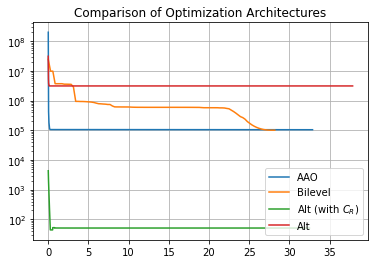

In [411]:
plt.plot(times_aao, aao_history, label="AAO")
plt.plot(times_bi, bi_history, label="Bilevel")
plt.plot(times_with, history_alt_with, label="Alt (with $C_R$)")
plt.plot(times_without, history_alt_without, label="Alt")
#plt.ylim(-1e7,2e7)
#plt.ylim(-1e7,1e6)
plt.yscale("log")
plt.grid()
plt.legend()
plt.title("Comparison of Optimization Architectures")
fig = plt.gcf()

In [412]:
fig.savefig('notional_comparison.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

In [413]:
tab = pd.DataFrame(columns = ["x_p", "x_a", "x_r", "x_s", "x_b", "x_c"])
tab.loc['aao'] = list(result_aao['x'])
tab.loc['bilevel'] = list(result_bi['x']) + list(args['xres'])
tab.loc['alt_without'] = list(xdes_without) + list(xres_without)
tab.loc['alt_with'] = list(xdes_with) + list(xres_with)

In [414]:
tab

,x_p,x_a,x_r,x_s,x_b,x_c
aao,0.909073,1.011279e-06,0.999992,0.909072,1.286547,2.156015
bilevel,0.909091,1.002271e-06,0.999987,0.909090,16.147316,5.988630
alt_without,0.959120,5.503226e-01,0.281629,0.408798,0.095318,20.000000
alt_with,0.832109,9.690882e-09,0.999492,0.832109,99.999997,20.000087


In [364]:
res_cost(xres_without,xdes_without, const)

2462096.8079811865

In [365]:
xres_without

array([ 0.0774055 , 19.99999985])

In [371]:
xdes_without

array([0.98495453, 0.83449988, 0.14638619, 0.15045465])

In [232]:
result_bi

 barrier_parameter: 0.00016000000000000007
 barrier_tolerance: 0.00016000000000000007
          cg_niter: 241
      cg_stop_cond: 4
            constr: [array([-2.22044605e-16]), array([0.12474944]), array([0.9456091 , 0.89115089, 0.00373458, 0.0544582 ])]
       constr_nfev: [159, 159, 0]
       constr_nhev: [0, 0, 0]
       constr_njev: [159, 159, 0]
    constr_penalty: 1.0
  constr_violation: 2.220446049250313e-16
    execution_time: 33.289212703704834
               fun: 251358.77860831958
              grad: array([-108781.7890625 ,  193282.22460938,  100616.78515625,
        108916.42578125])
               jac: [array([[ 1, -1,  0, -1]]), array([[ 0.        , -0.29584538, -1.        ,  0.        ]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])]
   lagrangian_grad: array([ 8.40886790e+03,  8.46114191e+03, -8.38840984e-01, -5.22740099e+01])
           message: 'The maximum number of function evaluations is exceeded.'
       